# The Second Part of the Assignment of IDS 2020-2021
In this Jupyter notebook, please, document your results and the way you have obtained them. Please use the _Python environment_ provided at the beginning of the course. In addition to the _Jupyter notebook_, please submit _one zip-file_ containing all datasets and other outputs you have generated (such as pdf, jpg, and others). Please make sure that the datasets and other outputs are easily identifiable, i.e. use names as requested in the corresponding question.

This is the _only_ submission that is required (Jupyter notebook + zip-file). A separate report is _not_ needed and will not be considered for grading. 

Give your commented Python code and answers in the corresponding provided cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. <b>Please DO NOT CLEAR THE OUTPUT of the notebook you are submitting! </b>

It is not needed that the group members be the same as the group members of the first part of the assignment, <font color="red"> *Please make sure to include names and matriculation numbers of all group members in the slot provided below.* </font> If a name or a student's matriculation number is missing, the student will not receive any points.

Hint 1: While working on the assignment, you will get a better understanding of the datasets. Feel free to generate additional results and visualizations to support your answers. For example, this might be useful regarding data modification and simplification. <font color="red">Ensure that all your claims are supported.</font>

Hint 2: <font color="red">Plan your time wisely. </font> A few parts of this assignment might take some time to run. It might be necessary to consider time management when you plan your group work.

Hint 3: RWTHmoodle allows multiple submissions, with every new submission overwriting the previous one. <b>Partial submissions are therefore possible and encouraged. </b> This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

<font color="red"><b>Student Names and matriculation numbers:
    
    1. Peter Konradi - 402367
    
    2. Mridul Mani Tripathi - 403587

    3. Rohan Krishna Balaji - 403596

In [ ]:
# inflect needed to convert numbers to words (for Question 2)
!pip install inflect
# (for Question 1.4 )
!pip install -U gensim
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [1]:
# basic stack as defined in software
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, metrics
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np
from scipy import stats
import seaborn as sns
from p_decision_tree.DecisionTree import DecisionTree
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# internals
import inspect
from typing import NewType
import itertools
import functools as func
import operator

# inflect needed to convert numbers to words (for Question 2)
import inflect
# seaborn for distribution
import seaborn as sns

rand_seed = 403596
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 500
pd.set_option('display.max_colwidth', -1)

In [3]:
IdsType = NewType('IdsType',str)

class IdsTypes:
    time = IdsType('Time')
    num = IdsType('Numerical')
    cat = IdsType('Categorical')
    bl = IdsType('Boolean')

class Column(str):  
    def __new__(cls,name:str,idstype:IdsType):
        obj = str.__new__(cls,name)
        obj.idstype = idstype
        return obj
    
class CatCol(Column):
    def __new__(cls,name:str):
        obj = Column.__new__(cls,name, IdsTypes.cat)
        return obj
    
    def convert(self,ds_col):
        return pd.Categorical(ds_col)
    
class NumCol(Column):
    def __new__(cls,name:str):
        obj = Column.__new__(cls,name, IdsTypes.num)
        return obj
    
    def convert(self,ds_col):
        return pd.to_numeric(ds_col)

class BoolCol(Column):
    def __new__(cls, name:str):
        obj = Column.__new__(cls,name,IdsTypes.bl)
        return obj

    def convert(self, col):
        return col.astype('bool')


## Question 1 - Data Preprocessing and Data Quality (15 points)

In [4]:
class VizData:
    file_name = './Datasets/DataPrepViz.csv'
    sampled_file_name = './output/dataPrepViz_sampled.csv'
    __original_ds__ = None
    __sampled_ds__ = None
    
    def load_original(force_reload = False):
        if force_reload or VizData.__original_ds__ is None:
            VizData.__original_ds__ = VizData.apply_categories(pd.read_csv(VizData.file_name, sep=";"))
        return VizData.__original_ds__.copy()
    
    def load_sampled(force_reload = False):        
        if force_reload or VizData.__sampled_ds__ is None:
            VizData.__sampled_ds__ = VizData.apply_categories(pd.read_csv(VizData.sampled_file_name, index_col=0))
        return VizData.__sampled_ds__.copy()
    
    def apply_categories(df):
        for w in VizData.Cols.as_set():
            df[w] = w.convert(df[w])
        return df

    class Cols:
        geog = CatCol('geographic_group')
        country = CatCol('country')
        fert = NumCol('children_per_woman_total_fertility')
        child_mort = NumCol('child_mortality_0_5_year_olds_dying_per_1000_born')
        co2 = NumCol('co2_emissions_tonnes_per_person')
        corruption = NumCol('corruption_perception_index_cpi')
        life_exp = NumCol('life_expectancy_years')
        vccn_eff = NumCol('vccin_effect_dag')


        __intset__ = None
        __transdict__ = None

        def _intset_():
            if VizData.Cols.__intset__ is None:
                VizData.Cols.__intset__ = frozenset({val for _,val in inspect.getmembers(VizData.Cols, lambda attr:isinstance(attr,Column))})
            return VizData.Cols.__intset__
            
            
        def _transdict_():
            if VizData.Cols.__transdict__ is None:
                VizData.Cols.__transdict__ = {v:v for v in VizData.Cols.as_set()}
            return VizData.Cols.__transdict__
            
        def as_set():
            return {v for v in VizData.Cols._intset_()}
        
        def as_list():
            return [v for v in VizData.Cols._intset_()]

(a) Carry out the following preprocessing steps before starting the analysis:

Select 90% of dataset <b>dataPrepViz.csv</b> for this assignment by random sampling. Use the matriculation number of one of the group members as seed. Rename the sampled dataset to <b>dataPrepViz_sampled</b> and export it as CSV.

 - <font color='red'>Important!</font> Make sure that you submit your extracted dataset with your results in Moodle.

Use this dataset <b>dataPrepViz_sampled</b> as starting point for Question 1 and Question 2. Then apply further modifications as specified in the those questions.

In [20]:
class Q1_a:
    def __init__(self, df):
        self.df = df

    def run(self):
        sampled = self.df.sample(frac=0.9, random_state=rand_seed)
        sampled.to_csv(VizData.sampled_file_name)
        return sampled

dataPrepViz_sampled = Q1_a(VizData.load_original()).run()

In [5]:
dataPrepViz_sampled = VizData.load_sampled()

Create new dataset <b>data1</b> by removing the feature 'geographic_group' from <b>dataPrepViz_sampled</b>. Use this <b>data1</b> dataset for Question 1.

In [92]:
data1 = dataPrepViz_sampled.drop(columns=[VizData.Cols.geog])

(b) We want to get a first impression of the data. To achieve this, compute and show the following:

- the column names (the names of the features)
- the data type of each feature
- for categorical features: the number of classes and the value of the most frequent class
- for numerical features: the mean, standard deviation, minimum and maximum

In [93]:
class Q1_b:
    def __init__(self, df):
        self.df = df
            
    def run(self):
        self.column_dt()
        self.cat_stat()
        self.num_stat()
        return self

    def column_dt(self):
        print('-----------')
        print('Feature names and types:')
        display(self.df.dtypes)

    def cat_stat(self):
        print('---------')
        print('Categorical stats:')
        display(self.df.select_dtypes(['category']).describe())

    def num_stat(self):
        print('---------')
        print('Numerical stats:')
        display(self.df.select_dtypes(['float64']).describe())
            

        

q1_b = Q1_b(data1).run()

-----------
Feature names and types:


country                                              category
children_per_woman_total_fertility                   float64 
child_mortality_0_5_year_olds_dying_per_1000_born    float64 
co2_emissions_tonnes_per_person                      float64 
corruption_perception_index_cpi                      float64 
life_expectancy_years                                float64 
vccin_effect_dag                                     float64 
dtype: object

---------
Categorical stats:


country
count   126     
unique  126     
top     Zimbabwe
freq    1

---------
Numerical stats:


children_per_woman_total_fertility  \
count  126.000000                           
mean  -0.593413                             
std    5.882875                             
min   -10.000000                            
25%   -10.000000                            
50%    1.955000                             
75%    2.992500                             
max    7.290000                             

       child_mortality_0_5_year_olds_dying_per_1000_born  \
count  126.000000                                          
mean   30.579365                                           
std    32.329526                                           
min    2.180000                                            
25%    5.012500                                            
50%    15.700000                                           
75%    51.675000                                           
max    130.000000                                          

       co2_emissions_tonnes_per_person  corruption_perception_index_cpi  \
count  126.000000                       125.000000                        
mean   4.471074                         44.864000                         
std    4.730903                         20.630131                         
min    0.036700                         11.000000                         
25%    0.632500                         29.000000                         
50%    3.050000                         38.000000                         
75%    6.662500                         58.000000                         
max    24.100000                        91.000000                         

       life_expectancy_years  vccin_effect_dag  
count  126.000000             60.000000         
mean   72.915079              0.082950          
std    7.671788               0.049454          
min    55.800000              0.000000          
25%    66.975000              0.051000          
50%    74.750000              0.072000          
75%    79.475000              0.107000          
max    84.400000              0.260000

(c) For each feature, provide a histogram (with at least 10 bins each) showing the value distribution. Can you spot any obvious data quality issues, e.g. inconsistencies, implausible values or missing values (without researching on specific domain knowledge)?

Briefly explain the issues you identified.

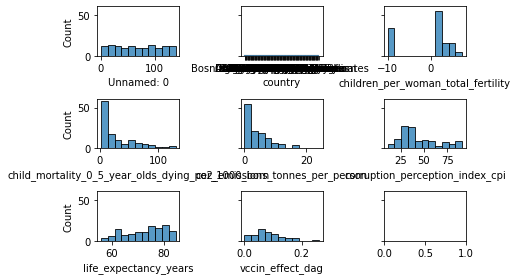

In [74]:
class Q1_c:

    def __init__(self, df):
        self.df = df

    def run(self, m = 3, bins=11):
        n = (self.df.shape[1]//m + (self.df.shape[1]%m > 0))
        f, axs = plt.subplots( n, m, sharey=True)
        for i,feature in enumerate(self.df.columns.values):
            sns.histplot(data=self.df, x=feature, ax=axs[i//m, i%m], bins=bins)

        f.tight_layout()
        return self

q1_c = Q1_c(data1).run()

Explanation: 
* `children_per_woman_total_fertility` contains negative values


(d) Substitute all implausible values as missing data (numpy.nan). Show the scatter matrix of the resulting dataset.

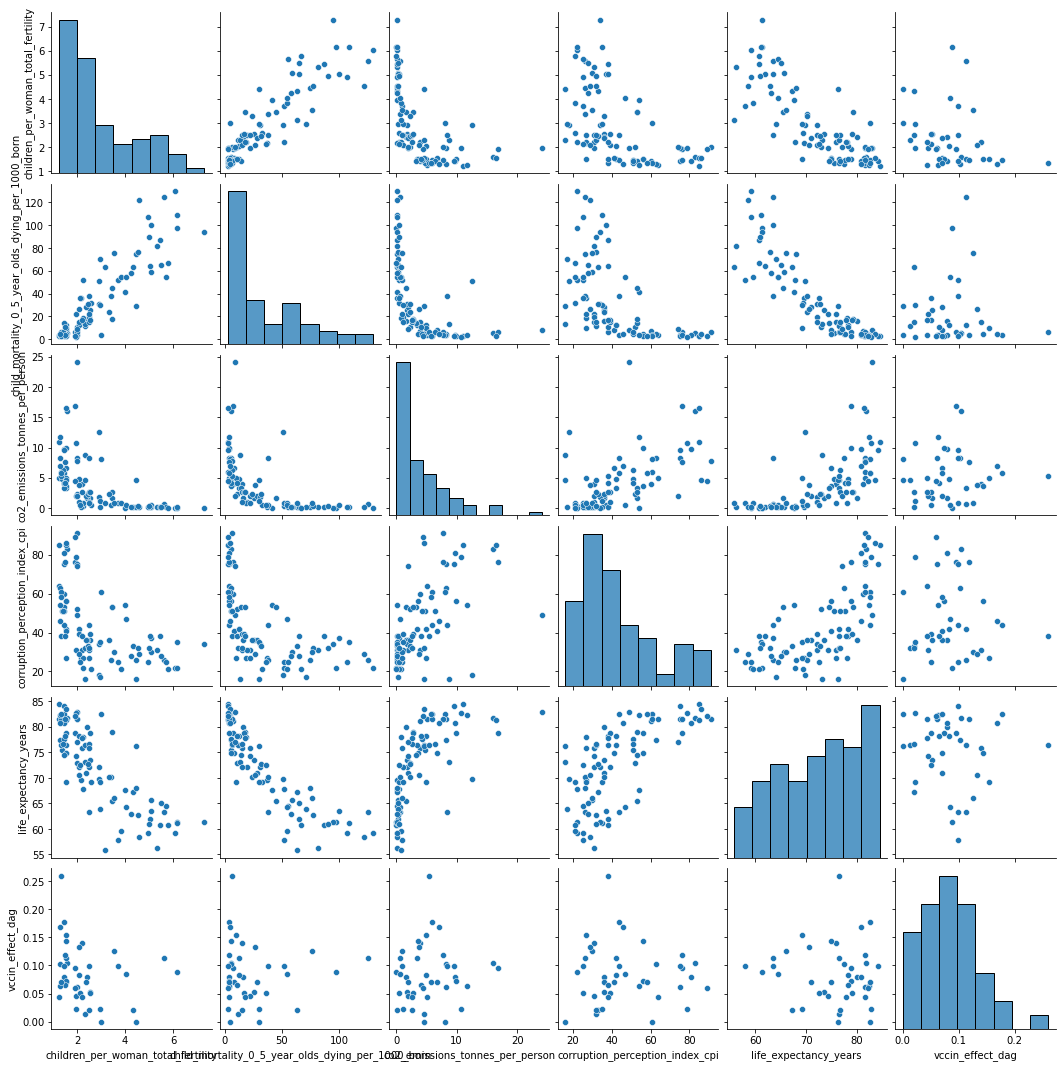

In [94]:
class Q1_d:

    def __init__(self, df):
        self.df = df

    def run(self):
        for c in self.df.select_dtypes(['float64']).columns.values:
            self.df[self.df[c] < 0] = np.nan
        sns.pairplot(self.df, kind='scatter')
        return self

q1_d = Q1_d(data1).run()

(e) We need to handle any implausible or missing data. In the lecture, several strategies to do so have been introduced. 

In this question, consider implausible values to be the ones identified in part (c).

    1) For all numerical features, compute and show mean, standard deviation, minimum and maximum, while ignoring the missing and implausible values. Also, print the total number of data rows.
    
    2) Based on the information obtained in the previous subtasks of this question, choose a strategy for handling all missing/implausible values, such that
    - for one feature, you delete all data rows that include a missing value.
    - for one feature, you replace all missing values by the median value.
    - for one feature, you impute the values based on other, continous features using a regression classifier.
    Create a cleaned dataset with all those values handled accordingly. 
    
    3) For all numerical features, compute and show mean, standard deviation, minimum and maximum with respect to your cleaned dataset. Also print the total number of data rows.
    
    4) Motivate and explain the choices you made in 2). Compare the computed statistical values before and after cleaning and briefly describe and evaluate any changes.
 
*Hint: There might not be an obvious choice for the best strategy. In this case, sound reasoning based on correct observations is more important than the decision itself.*

In [103]:
from sklearn.linear_model import LinearRegression

class Q1_e:
    numerical_features = []

    def __init__(self, df):
        self.df = df.copy()

    def run(self):
        before = self.stats_before()
        df = self.df
        df = Q1_e.drop_rows(df)
        df = Q1_e.substitute_median(df)
        self.df = Q1_e.interpolate_regr(df)
        after = self.stats_after()
        print('--------')
        print('differences old v new')
        display(after - before)
        return self

    def drop_rows(df, feature=VizData.Cols.country):
        return df.drop(labels=df[df[feature].isnull()].index.values)

    def interpolate_regr(df, feature=VizData.Cols.vccn_eff):
        df_nn = df[df[feature].notnull()]
        X = df_nn.drop(columns=[feature]).select_dtypes(['float64'])
        y = df_nn[feature]
        clf=LinearRegression().fit(X,y)
        X_inp = df.drop(columns=[feature]).select_dtypes(['float64'])
        for i in df[df[feature].isnull()].index.values:
            pred = clf.predict(X_inp.loc[[i]])
            if pred < 0:
                pred = 0
            df[feature].loc[i] = pred
        return df

    
    def substitute_median(df, feature=VizData.Cols.corruption):
        med = df[feature].median()
        df[feature] = df[feature].fillna(med)
        return df

    def stats_before(self):
        print('-------')
        print('Numerical feature stats before cleaning:')
        pdf = pd.DataFrame({feature:[d.mean(), d.std(), d.min(), d.max(), d.notnull().sum()] for feature, d in self.df.select_dtypes(['float64']).iteritems() }).set_index(pd.Series(['mean', 'std', 'min', 'max', '# values']))
        print(len(self.df.notnull()))
        display(pdf)
        return pdf

    def stats_after(self):
        print('-------')
        print('Numerical feature stats after cleaning:')
        pdf = pd.DataFrame({feature:[d.mean(), d.std(), d.min(), d.max(), d.notnull().sum()] for feature, d in self.df.select_dtypes(['float64']).iteritems() }).set_index(pd.Series(['mean', 'std', 'min', 'max', '# values']))
        print(len(self.df))
        display(pdf)
        return pdf

q1_e = Q1_e(q1_d.df).run()
        
        

-------
Numerical feature stats before cleaning:
126


children_per_woman_total_fertility  \
mean      2.882935                             
std       1.503682                             
min       1.240000                             
max       7.290000                             
# values  92.000000                            

          child_mortality_0_5_year_olds_dying_per_1000_born  \
mean      33.919457                                           
std       33.877509                                           
min       2.180000                                            
max       130.000000                                          
# values  92.000000                                           

          co2_emissions_tonnes_per_person  corruption_perception_index_cpi  \
mean      3.962905                         43.098901                         
std       4.546439                         19.547125                         
min       0.036700                         16.000000                         
max       24.100000                        91.000000                         
# values  92.000000                        91.000000                         

          life_expectancy_years  vccin_effect_dag  
mean      72.336957              0.083349          
std       7.989990               0.051712          
min       55.800000              0.000000          
max       84.400000              0.260000          
# values  92.000000              43.000000

-------
Numerical feature stats after cleaning:
92


children_per_woman_total_fertility  \
mean      2.882935                             
std       1.503682                             
min       1.240000                             
max       7.290000                             
# values  92.000000                            

          child_mortality_0_5_year_olds_dying_per_1000_born  \
mean      33.919457                                           
std       33.877509                                           
min       2.180000                                            
max       130.000000                                          
# values  92.000000                                           

          co2_emissions_tonnes_per_person  corruption_perception_index_cpi  \
mean      3.962905                         43.032609                         
std       4.546439                         19.449823                         
min       0.036700                         16.000000                         
max       24.100000                        91.000000                         
# values  92.000000                        92.000000                         

          life_expectancy_years  vccin_effect_dag  
mean      72.336957              0.079507          
std       7.989990               0.045528          
min       55.800000              0.000000          
max       84.400000              0.260000          
# values  92.000000              92.000000

--------
differences old v new


children_per_woman_total_fertility  \
mean      0.0                                  
std       0.0                                  
min       0.0                                  
max       0.0                                  
# values  0.0                                  

          child_mortality_0_5_year_olds_dying_per_1000_born  \
mean      0.000000e+00                                        
std       7.105427e-15                                        
min       0.000000e+00                                        
max       0.000000e+00                                        
# values  0.000000e+00                                        

          co2_emissions_tonnes_per_person  corruption_perception_index_cpi  \
mean      0.0                             -0.066292                          
std       0.0                             -0.097302                          
min       0.0                              0.000000                          
max       0.0                              0.000000                          
# values  0.0                              1.000000                          

          life_expectancy_years  vccin_effect_dag  
mean      1.421085e-14          -0.003842          
std       0.000000e+00          -0.006184          
min       0.000000e+00           0.000000          
max       0.000000e+00           0.000000          
# values  0.000000e+00           49.000000

Explanation: Techniques and their columns:
* _delete rows with missing values_: We applied this strategy to the `country` feature, as it is categorical and we would have had no way to (realisticly) compute missing values
* _replace missing values with median_: Applied to `corruption_perception_index_cpi`, since there is only 1 additional value missing. Hence this naive way of handling the missing data will have a much lesser impact then on the other features
* _impute values_: Applied to `vccin_effect_dag`, since here 49 values had to be replaced. Hence the impact was reduced, as is visible by the comparison table 

## Question 2 - Data Preprocessing and Advanced Visualization (15 points)

For this question, use the <b>dataPrepViz_sampled</b> dataset you created in Q1, part (a).

(a) To create a suitable input for the following questions, modify the dataset as listed below:

    1) remove rows that contain negative values
    2) remove all rows that contain missing values

In [6]:
class Q2_a:

    def __init__(self, df):
        self.df = df

    def run(self):
        for c in self.df.select_dtypes(['float64']).columns.values:
            self.df[self.df[c] < 0] = np.nan
        self.df.dropna(inplace=True)
        return self
q2_a = Q2_a(dataPrepViz_sampled).run()

(b) For this subtask remove the feature 'country' from the data. Create four parallel coordinate plots that visualize the relation between the numerical attributes for all geographic groups.

    1) For the first parallel coordinate plot, use the values unchanged.
    
    2-4) For the remaining 3 parallel coordinate plots, first normalize all numerical attributes by mapping them individually to the interval between 0 and 1, that is, apply Min-max normalization. Draw the three plots with different orderings of the features (randomized or chosen by interest).

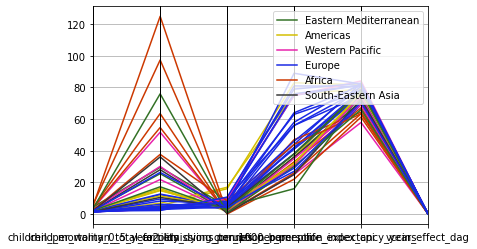

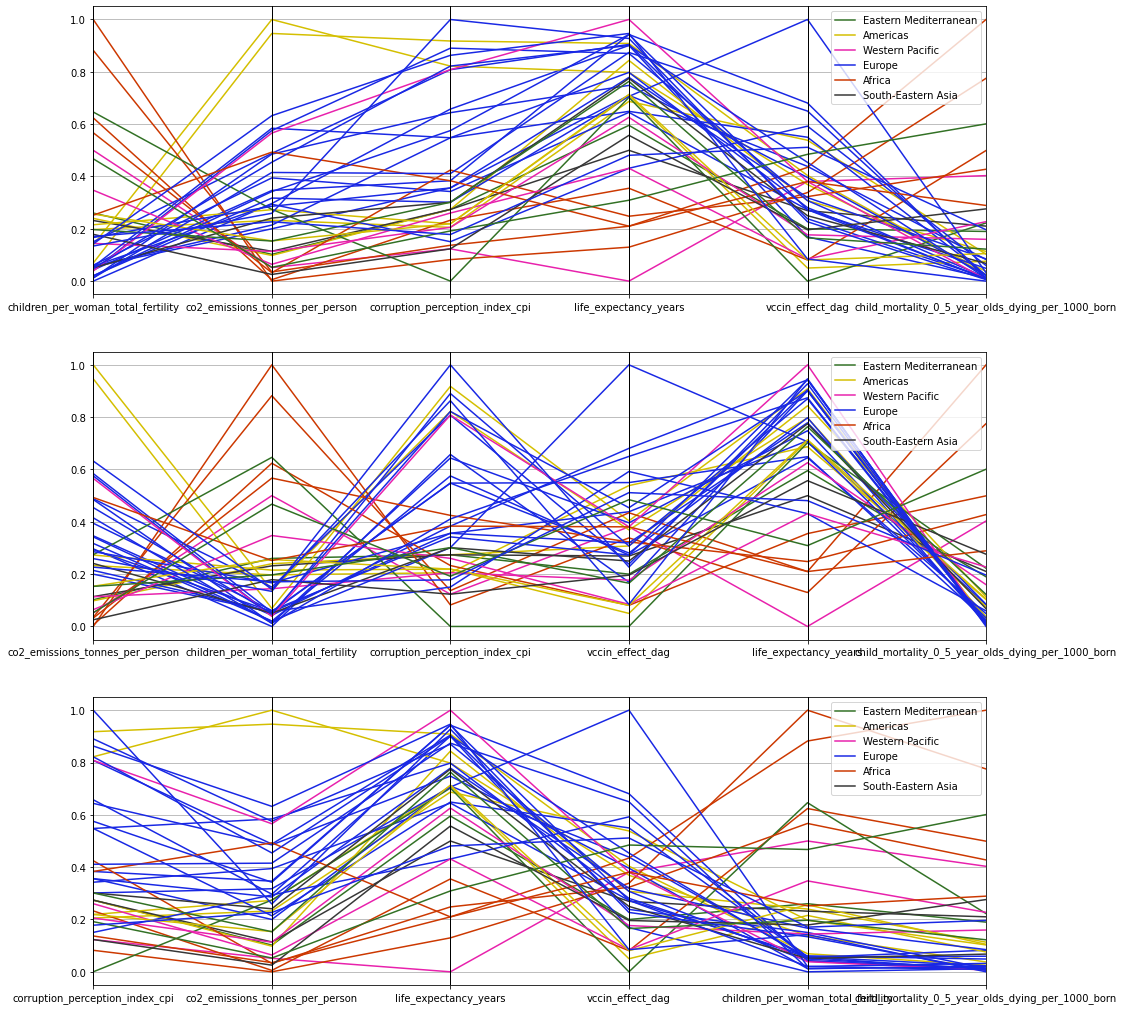

In [9]:
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler 
class Q2_b:
    args = {"color":('#327125', '#D4BF00', '#E821AC', '#1928E4', '#CC3800', '#373737' )}
    def __init__(self, df):
        self.df = df.drop(columns=[VizData.Cols.country])

    def run(self):
        
        parallel_coordinates(self.df, VizData.Cols.geog,  **Q2_b.args)
        df_scaled = Q2_b.scale(self.df)
        f, axs = plt.subplots(3,1, figsize=(16,18))
        parallel_coordinates(df_scaled[[VizData.Cols.fert, VizData.Cols.co2, VizData.Cols.corruption, VizData.Cols.life_exp, VizData.Cols.vccn_eff, VizData.Cols.geog, VizData.Cols.child_mort]],  VizData.Cols.geog, ax=axs[0], **Q2_b.args)
        parallel_coordinates(df_scaled[[VizData.Cols.co2, VizData.Cols.fert,  VizData.Cols.corruption, VizData.Cols.vccn_eff, VizData.Cols.life_exp,  VizData.Cols.geog, VizData.Cols.child_mort]],  VizData.Cols.geog, ax=axs[1], **Q2_b.args)
        parallel_coordinates(df_scaled[[VizData.Cols.corruption, VizData.Cols.co2,  VizData.Cols.life_exp, VizData.Cols.vccn_eff, VizData.Cols.fert,   VizData.Cols.geog, VizData.Cols.child_mort]],  VizData.Cols.geog, ax=axs[2], **Q2_b.args)
        
        
        return self

    def scale(df):
        df_scaled = df.copy()
        for c in df_scaled.select_dtypes(['float64']).columns.values:
            df_scaled[c] = MinMaxScaler().fit_transform(np.array(df[c]).reshape(-1,1))
        return df_scaled


q2_b = Q2_b(q2_a.df).run()

(c) For each of the questions 1-3 below:
- Indicate all of your parallel coordinate plots, which are suitable for finding an answer to the question. Explain your selection. 
- If possible, briefly answer the questions.

    1) Is there a correlation between fertility and CO2 emissions? If yes, is it positive or negative?

    2) Is there a correlation between life expectancy and vaccination confidence? If yes, is it positive or negative?

    3) Is there a correlation between CO2 emissions and perceived corruption? If yes, is it positive or negative?

Explanation: 
The plots have been chosen so that the features in question were neighbours.

1. (Scaled plots 1 & 2): As there are multiple lines crossing each other, pratially in clusters, there seems to be a negative correlation between those.
2. (All scaled plots): While there again are some lines crossing each other, they are more sparse, while most lines are nearly parallel, indicating a positive correlation.
3. (Scaled plots 1 & 3): Again, it looks more like a positive correlation.

(d) In this subtask we prepare the data for the heat map, which we create in subtask (e). 

The heat map should visualize the vaccination confidence ('vccin_effect_dag') for different combinations of CO2 emissions ('co2_emissions_tonnes_per_person') and fertility ('children_per_woman_total_fertility'). The heatmap should have 40 columns and 40 rows. The shown vaccination confidence value should be the *median* of all values for each combination of CO2 emissions and fertility. 

Do the following steps in preparation:

    1) First, drop all columns that are not needed in this task.

    2) Discretize the CO2 emissions and fertility data into 40 bins each, using equal-width binning.

    3) Group the data by CO2 emissions and fertility, using median to aggregate the values.

In [16]:
class Q2_d:
    target_feature = VizData.Cols.vccn_eff
    exp_features = [VizData.Cols.co2, VizData.Cols.fert]
    heatmap_size = (40,40)

    def __init__(self, df):
        self.df = df[Q2_d.exp_features + [Q2_d.target_feature]].copy()

    def run(self):
        for i,ef in enumerate( Q2_d.exp_features):
            self.df[ef] = pd.cut(self.df[ef], bins=Q2_d.heatmap_size[i])
        self.df = self.df.groupby(Q2_d.exp_features).median()
        self.df.reset_index(inplace=True)
        self.df = self.df.pivot(index=Q2_d.exp_features[0], columns=Q2_d.exp_features[1], values=Q2_d.target_feature)

        return self

q2_d = Q2_d(VizData.load_sampled()).run()

(e) Use the modified data to create a heat map as specified in part (d). Answer the following questions based on that heat map and briefly explain how you derived your answer:

    1) Which combination of bins results in the highest vaccination confidence? 
    
    2) How do you explain empty fields in your heat map?
    
    3) Can you identify any pattern in the heat map, e.g. in the coloring or in the distribution of empty fields? What can be a possible reason for this?

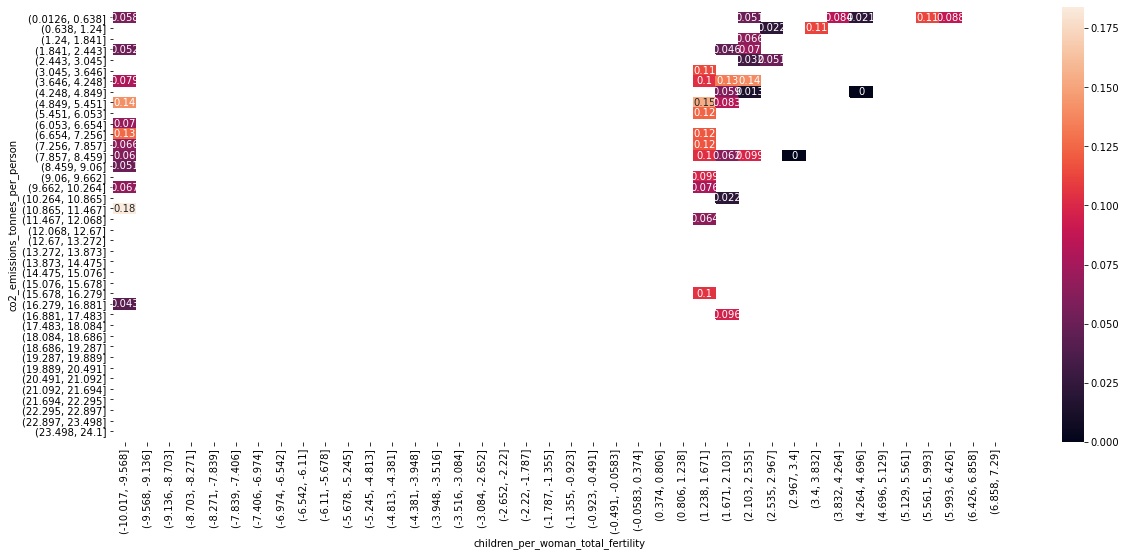

In [17]:
class Q2_e:

    def __init__(self, df):
        self.df = df

    def run(self):
        f, ax = plt.subplots(figsize=(20, 8))
        sns.heatmap(self.df, annot=True, ax=ax)
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)

        return self

q2_e = Q2_e(q2_d.df).run()

Explanation: 

1) Biggest confidence is 0.18 for fertility (-10.017, -9.568] and emissions (10.865, 11.467]. Looking at the highest value in ranges which are valid, it would be 0.15 for fertility (1.238, 1.671] and emissions (4.849, 5.451]

2) There aren't any values for the combination of those bins

3) Besides there beeing an awfull lot of white space, the valid part of the data gets lighter while moving to lower bins of the fertility.

## Question 3 - Frequent Item Sets and Association Rules (15 points)

In [19]:
import csv
import random
import numpy as np
import math
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule

In [20]:
class StoreData:
    file_name = './Datasets/store_data.csv'
    cleaned_file_name = 'store_data_2.csv'
    __original_ds__ = None
    __cleaned_ds__ = None
    
    def load_original(force_reload = False):
        if force_reload or StoreData.__original_ds__ is None:
            csv_ds = StoreData.get_csv(StoreData.file_name)
            StoreData.__original_ds__ = StoreData.csv_to_pandas(csv_ds)
        return StoreData.__original_ds__.copy()
    
    def load_cleaned(force_reload = False):        
        if force_reload or StoreData.__cleaned_ds__ is None:
            csv_ds = StoreData.get_csv(StoreData.cleaned_file_name)
            StoreData.__cleaned_ds__ = StoreData.csv_to_pandas(csv_ds)
        return StoreData.__cleaned_ds__.copy()
    
    def get_csv(filename):
        data_set = list()
        with open(filename, 'r') as csvFile:
            reader = csv.reader(csvFile)
            for row in reader:
                data_set.append(list([i for i in row if i != '']))
        return data_set
    
    def csv_to_pandas(csv_ds):
        te = TransactionEncoder()
        te_t = te.fit(csv_ds).transform(csv_ds)
        df = pd.DataFrame(te_t, columns=te.columns_)
        return df

(a) Carry out some preprocessing steps before starting the analysis:
 - Select 90% of the <b>store_data</b> dataset by random sampling. Use the matriculation number of one of the group members as seed.
 - After completing this preprocessing step, export your final dataset as <b>store_data_2.csv</b> dataset and use it for the next steps of the assignment.
 - <font color='red'>Important!</font> Make sure that you submit your extracted dataset with your results in Moodle.

In [21]:
class Q3_a:
    def run(self):
        csv_ds = StoreData.get_csv(StoreData.file_name)
        n = len(csv_ds) * 0.9
        n = math.ceil(n)
        random.seed(rand_seed)
        sampled = [csv_ds[i] for i in sorted(random.sample(range(len(csv_ds)),n))]
        with open(StoreData.cleaned_file_name, 'w') as f:
            writer = csv.writer(f)
            writer.writerows(sampled)
        return self

q3_a = Q3_a().run()

(b) Find the most frequent itemsets with the support of more than 0.04 using the Apriori algorithm.

In [22]:
 class Q3_b:
    def run(self):
        df = StoreData.load_cleaned()
        frequent_itemsets = apriori(df, min_support = 0.04, use_colnames = True)
        display(frequent_itemsets.sort_values(by=['support'], ascending=False).head(5))
        self.freq_sets = frequent_itemsets.copy()
        return self
    
q3_b = Q3_b().run()

support         itemsets
20  0.240409  (mineral water)
7   0.178640  (eggs)         
26  0.175678  (spaghetti)    
9   0.170790  (french fries) 
4   0.164420  (chocolate)

(c) Find the most frequent itemsets with more than 1 member and a support of more than 0.04 using the Apriori algorithm.

In [23]:
class Q3_c:
    def __init__(self, freq_sets):
        self.freq_sets = freq_sets
        
    def run(self):
        frequent_itemsets = self.freq_sets
        frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
        frequent_itemsets_filtered = frequent_itemsets[(frequent_itemsets['length'] > 1)]  
        display(frequent_itemsets_filtered.sort_values(by=['support', 'length'], ascending=False).head(5))
        return self
q3_c = Q3_c(q3_b.freq_sets.copy()).run()

support                      itemsets  length
34  0.061472  (spaghetti, mineral water)    2     
30  0.053918  (chocolate, mineral water)    2     
31  0.051696  (eggs, mineral water)         2     
33  0.048437  (milk, mineral water)         2     
32  0.041772  (ground beef, mineral water)  2

(d) Find the itemsets having min_confidence=0.3 and min_lift=1.2. Print support, confidence, and lift of the filtered rules in one table. How do you interpret the quality of the discovered rules?

In [24]:
class Q3_d:
    def __init__(self, freq_sets):
        self.freq_sets = freq_sets
        
    def run(self):
        df = StoreData.load_cleaned()
        frequent_itemsets = apriori(df, min_support = 0.04, use_colnames=True)
        rules = arule(frequent_itemsets, metric = 'lift', min_threshold = 1.2)
        display(rules[(rules['confidence'] > 0.3)].drop(columns=["leverage", "conviction"]))
        return self
q3_d = Q3_d(q3_b.freq_sets.copy()).run()

antecedents      consequents  antecedent support  consequent support  \
0  (chocolate)    (mineral water)  0.164420            0.240409             
4  (ground beef)  (mineral water)  0.098208            0.240409             
6  (milk)         (mineral water)  0.128425            0.240409             
8  (spaghetti)    (mineral water)  0.175678            0.240409             

    support  confidence      lift  
0  0.053918  0.327928    1.364043  
4  0.041772  0.425339    1.769234  
6  0.048437  0.377163    1.568839  
8  0.061472  0.349916    1.455503

Explanation:
When taking a look at the combined support of the rules, it is relatively low. Same for the antecedent support. When looking at the consequent support, it becomes clear why mineral water is the consequent for all 4 filtered rules (nearly .25!). When looking at the lift values, they are well over 1, indicating that the rules appear much more often then expected.

(e) Apply the FP-Growth algorithm for all the settings of b, c, and d.

In [25]:
from mlxtend.frequent_patterns import fpgrowth
class Q3_e:

    def __init__(self, df):
        self.df = df

    def run(self):
        f_items = self.fpg()
        c = Q3_c(f_items).run()
        d = Q3_d(f_items).run()

        return self


    def fpg(self):
        frequent_itemsets = fpgrowth(self.df, min_support = 0.04, use_colnames = True)
        display(frequent_itemsets.sort_values(by=['support'], ascending=False).head(5))
        return frequent_itemsets

q3_e = Q3_e(StoreData.load_cleaned()).run()

support         itemsets
0   0.240409  (mineral water)
13  0.178640  (eggs)         
17  0.175678  (spaghetti)    
11  0.170790  (french fries) 
19  0.164420  (chocolate)

support                      itemsets  length
32  0.061472  (spaghetti, mineral water)    2     
33  0.053918  (chocolate, mineral water)    2     
31  0.051696  (eggs, mineral water)         2     
30  0.048437  (milk, mineral water)         2     
34  0.041772  (ground beef, mineral water)  2

antecedents      consequents  antecedent support  consequent support  \
0  (chocolate)    (mineral water)  0.164420            0.240409             
4  (ground beef)  (mineral water)  0.098208            0.240409             
6  (milk)         (mineral water)  0.128425            0.240409             
8  (spaghetti)    (mineral water)  0.175678            0.240409             

    support  confidence      lift  
0  0.053918  0.327928    1.364043  
4  0.041772  0.425339    1.769234  
6  0.048437  0.377163    1.568839  
8  0.061472  0.349916    1.455503

## Question 4 - Text Mining (15 points): 

In this question, we use <b>sms_data.csv</b>. 

In [26]:
from gensim.models import Doc2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.linear_model import LogisticRegression
import string
import multiprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

from numpy.random import RandomState
from nltk.corpus import stopwords

from sklearn import utils

In [40]:
class Texts:
    right_padding = '<'
    left_padding = '>' 
    cc = multiprocessing.cpu_count()
    
    def default_regressor():
        return LogisticRegression(random_state=rand_seed, solver='liblinear', multi_class= 'auto')
    


a) Load the dataset and create the <b>sampled_data</b> dataset which includes 90% of the data. Use the matriculation number of one of the group members as seed. Export the sampled dataset. Split the sampled data into training (80%) and test (20%) data preserving the distribution based on "Label".

<font color='red'>Important!</font> Make sure that you submit your extracted dataset with your results in Moodle.

In [30]:
class Q4_a:

    def run(self):
        self.df = pd.read_csv('./Datasets/sms_data.csv', sep=";", encoding='cp1252').sample(frac=0.9, random_state=rand_seed)
        self.df['Label'] = self.df['Label'].astype('category')
        self.df['Text'] = self.df['Text'].astype('str')
        self.df.to_csv('./output/sms_sampled.csv')
        X = self.df["Text"]
        y = self.df["Label"]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=0.8, random_state=rand_seed, stratify=y)
        self.train = (self.X_train, self.y_train)
        self.test = (self.X_test, self.y_test)
        return self

q4_a = Q4_a().run()

### Classification

In the following tasks, train each of the specified models with the training data and give for each the accuracy on the training data.

(b) Model based on the binary document-term matrix

Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, and stopword removal) and obtain a binary document-term matrix. Train a logistic classifier with the 'Label' as target feature.

In [31]:
class Q4_b:
    
    def __init__(self,data, target ):
        self.target = target
        self.data = data
    
    def run(self):
        actual_analyzer = HashingVectorizer(stop_words='english', binary=True, preprocessor=lambda line: line.translate(str.maketrans('', '', string.punctuation))).build_analyzer()
        snowball_stemmer = SnowballStemmer('english', ignore_stopwords=True)
        pipe = Pipeline([('vectorizer',HashingVectorizer(analyzer = lambda doc: (snowball_stemmer.stem(w) for w in actual_analyzer(doc))))\
                         ,('logistic', Texts.default_regressor())])
        self.classifier = pipe.fit(self.data, self.target)
        return self

        
q4_b = Q4_b(*q4_a.train).run()

(c) Model based on doc2vec

- Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, and stopword removal). 
- Obtain a doc2vec embedding in order to reduce the dimension of the document vector. Explain which vector size you use and why.
- Use the doc2vec model you just trained to convert the training set to a set of document vectors.
- Train a logistic classifier with 'Label' as target feature.

In [32]:
from gensim.models import Doc2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument
from numpy.random import RandomState
from nltk.corpus import stopwords

from sklearn import utils

class Q4_c:
    
    def __init__(self,data, target ):
        self.target = target
        self.data = data
    
    def run(self):
        docs = Q4_c.makeTaggedDocs(self.target,self.data)
        d2vModel = Q4_c.d2vModel(docs)
        Q4_c.train_model(d2vModel, docs)
        
        dData, dTarget = Q4_c.learningVector(d2vModel, docs)
        log_reg = Texts.default_regressor()
        self.d2vModel = d2vModel
        self.classifier = log_reg.fit(dData, dTarget)
        return self
    
    
    def learningVector(model,docs):
        d2Vectors = [model.infer_vector(doc.words) for doc in docs]
        targets = [doc.tags[0] for doc in docs]
        return d2Vectors,targets
    
    def train_model(model,docs,n=30):
        shuffle_state = RandomState(seed=rand_seed)
        for _ in range(n):
            model.alpha -= 0.002
            model.min_alpha = model.alpha
            model.train(utils.shuffle(docs, random_state=shuffle_state), total_examples=len(docs), epochs=1)
                
    
    def makeTaggedDocs(target,data):
        snowball_stemmer = SnowballStemmer('english', ignore_stopwords=True)
        stops = frozenset(stopwords.words('english'))
        lst = []
        for t,d in zip(target,data):
            lst.append(TaggedDocument(words=[snowball_stemmer.stem(w) for w in simple_preprocess(d) if w not in stops],tags=[t]))
        return lst
    
    def d2vModel(docs, n = 300):
        model = Doc2Vec(dm=0, vector_size=n, workers=Texts.cc, batch_words=1000)
        model.build_vocab(docs)
        return model
        
q4_c = Q4_c(*q4_a.train).run()

### Evaluation
For the following tasks, use the test data.

(d) Predict the classification with the two models on the test data. Preprocess the data if necessary.

In [33]:
class Q4_d:
    def __init__(self, testData, testTarget , models, d):
        self.testData = testData
        self.testTarget = testTarget
        self.models = models
        self.d2v = Q4_d.D2V(d)
        
    def run(self):
        self.predictions = [model.predict(self.testData) for model in self.models]
        self.d2v.run(self.testTarget, self.testData)
        return self
    
    class D2V:
        
        def __init__(self, d):
            self.d = d
        
        def run(self, testTarget, testData):
            testDocs = Q4_c.makeTaggedDocs(testTarget,testData)
            self.testVectors, self.testTargets = Q4_c.learningVector(self.d.d2vModel, testDocs)
            self.prediction = list(self.d.classifier.predict(self.testVectors))
            return self
            
     
q4_d = Q4_d(*q4_a.test, [q4_b.classifier], q4_c).run()

Explanation: We run the prediction for each model and then create a doc2vec vectors and prediction in the D2V class



(e) Obtain the confusion matrices for the two models and the prediction on the test data.

In [34]:
class Q4_e:
    def __init__(self, target, predictions, d2v):
        self.target = target
        self.predictions = predictions
        self.d2v = d2v

    def run(self):
        names = ['binary document-term model']
        for name,prediction in zip(names, self.predictions):
            print(name)
            display(pd.crosstab(np.array(self.target), np.array(prediction), rownames=['True'], colnames=['Predicted'], margins=True))
        print('word embedding model')
        display(pd.crosstab(np.array(self.d2v.testTargets), np.array(self.d2v.prediction), rownames=['True'], colnames=['Predicted'], margins=True))

q4_e = Q4_e(q4_a.y_test, q4_d.predictions, q4_d.d2v).run()

binary document-term model


Predicted  ham  spam   All
True                      
ham        868  0     868 
spam       32   103   135 
All        900  103   1003

word embedding model


Predicted  ham  spam   All
True                      
ham        853  15    868 
spam       98   37    135 
All        951  52    1003

(f) Obtain accuracy and F1-score for the prediction of the two different models on the test data.

In [35]:
from sklearn.metrics import accuracy_score,  f1_score

class Q4_f:
    def __init__(self, target, predictions, d2v):
        self.target = target
        self.predictions = predictions
        self.d2v = d2v
        
    def run(self):
        names = ['binary document-term model']
        for name,prediction in zip(names, self.predictions):
            print(name)
            print('\taccuracy: ' , accuracy_score(self.target, prediction))
            print('\tf1: ' , f1_score(self.target, prediction, average='weighted'))
            print()
        print('word embedding model')
        print('\taccuracy: ' , accuracy_score(self.d2v.testTargets, self.d2v.prediction))
        print('\tf1: ' , f1_score(self.d2v.testTargets, self.d2v.prediction, average='weighted'))
        
q4_f = Q4_f(q4_a.y_test, q4_d.predictions, q4_d.d2v).run()

binary document-term model
	accuracy:  0.9680957128614157
	f1:  0.9662396134157322

word embedding model
	accuracy:  0.8873379860418744
	f1:  0.8649058073418308


(g) Briefly comment on the quality of the two models. Interpret the results retrieved in the evaluation part.

Explanation:  The binary model outperforms the word embedding by a huge margin, for both accuracy and F1 score. However both models perform well.

### Language model

For the following tasks use the <b>sampled_data</b>.

(h) Create two lists, one for ham and one for spam, containing all messages.
For ham and spam separately, build a bigram language model using the initial dataset (before splitting to training and test data). Do not perform stemming nor stopword removal for this task, but apply other preprocessing steps, such as all to lowercase, no punctuation and tokenization. Use both right and left padding, and manage unknown terms by using a dedicated token.

In [41]:
from nltk import ngrams, word_tokenize
from nltk.util import pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline

class Q4_h:
    def __init__(self, trainSet, testSet, targetAuthors=['spam','ham'], n = 2, l_pad = Texts.left_padding, r_pad = Texts.right_padding):
        self.authors = trainSet[1].append(testSet[1])
        self.text = trainSet[0].append(testSet[0])
        self.targetAuthors = targetAuthors
        self.n = n
        self.l_pad = l_pad
        self.r_pad = r_pad
        self.buildNGramModel = lambda x: pad_sequence(x, self.n, pad_left=True, pad_right=True, left_pad_symbol=self.l_pad, right_pad_symbol=self.r_pad)
        
    def run(self):
        author_sentences = Q4_h.authorSentenceDict(self.authors,self.text)
        self.models = dict()
        self.vocabs = dict()
        for targetAuthor in self.targetAuthors:
            self.models[targetAuthor], self.vocabs[targetAuthor]  = padded_everygram_pipeline(self.n, [[word.lower()  for sentence in author_sentences[targetAuthor] for word in word_tokenize(sentence) if word.isalpha()]])
        return self

        
    def authorSentenceDict(authors, texts):
        d = dict()
        for author, text in zip(authors,texts):
            d[author] = d.get(author, ()) + tuple(sentence.strip() for sentence in text.split('.') if sentence.strip())
        return d

q4_h = Q4_h(q4_a.train, q4_a.test).run()

(i) For each message groups, use the correspondent language model from (h) to generate, using MLE, a sentence of fifteen words using the following terms as seed:
- 'hello'
- 'yes'
- 'but'

In [42]:
from nltk.lm import MLE
class Q4_i:
    def __init__(self, models, vocabs, l_pad, starters=['hello','yes','but'],n=2, ln = 15):
        self.models = models
        self.starters = starters
        self.vocabs = vocabs
        self.l_pad = l_pad
        #self.n = len(next(iter(models.values()))[0][0])
        self.n = n
        self.ln = 15
    
    def run(self):
        for author in self.models:
            print(author ,':')
            lm = self.fit(author)
            for starter in self.starters:
                txt_seed = ([self.l_pad]*(self.n - 1)) + [starter]
                print(f'{starter} (seed: {txt_seed})')
                print('\t', starter , ' '.join(lm.generate(text_seed=txt_seed, random_seed=rand_seed, num_words=self.ln)))
        return self

    def fit(self, author):
        lm = MLE(self.n)
        lm.fit(self.models[author], vocabulary_text=self.vocabs[author])
        return lm

    
q4_i = Q4_i(q4_h.models, q4_h.vocabs, q4_h.l_pad).run()

spam :
hello (seed: ['>', 'hello'])
	 hello from the top ringtone service representative on this week just text back we have won
yes (seed: ['>', 'yes'])
	 yes got our prize on to skilgme hack chat to no to be sending you is
but (seed: ['>', 'but'])
	 but left no was awarded of our customer service to no to be sending you is
ham :
hello (seed: ['>', 'hello'])
	 hello hi take smth now onion roast in next week if you and taylor money its
yes (seed: ['>', 'yes'])
	 yes i thk shld b its ok good morning thats my phone by the method of
but (seed: ['>', 'but'])
	 but i thk shld b its ok good morning thats my phone by the method of


(j) Build a trigram model with the same data as in the previous task. Use both right and left padding, and manage unknown terms by using a dedicated token.

In [43]:
q4_j = Q4_h(q4_a.train, q4_a.test, n=3).run()

(k) For each message group (ham and spam), use the correspondent language model from the previous qustion to generate, using MLE, a sentence of fifteen words using the following terms as seed:
- 'hello'
- 'yes'
- 'but'

In [44]:
q4_k = Q4_i(q4_j.models, q4_j.vocabs, q4_j.l_pad,n=3).run()

spam :
hello (seed: ['>', '>', 'hello'])
	 hello from orange for month free access for hrs then chrgd per day txt stop new
yes (seed: ['>', '>', 'yes'])
	 yes got mega bill dont giv a shit bailiff due in days i o want more
but (seed: ['>', '>', 'but'])
	 but left no message ur tonexs subscription has been resent as previous attempt failed due to
ham :
hello (seed: ['>', '>', 'hello'])
	 hello hi lou sorry it hurt you just must exist like rain hail and mist and
yes (seed: ['>', '>', 'yes'])
	 yes i thought you send that to him only saturday and sunday holiday so no work
but (seed: ['>', '>', 'but'])
	 but i think that tantrum finished so yeah pa but am up if i go out


(l) Compare the quality of the generated text. Which model performs better? In general, which differences are there in using trigrams as opposed to bigrams?

Explanation: The quality of the trigrams is surprisingly good, especially when considering that, the bigram models should perform better in theory, since the training dataset is relatively small. In this case, the trigram models may overfit and the propability of unseen trigrams rises.

## Question 5 - Process Mining (15 points): 

### General investigation

a) Import the event log from the <b>Quarantine_Log</b> csv file. Set the case ID to 'patient', Timestamp to 'timestamp' and Activity as 'activity'. Also, set the lifecyle column to the right attribute. Furthermore, identify the case attributes and set them to case attributes. Find the correct setting, so that the resource is understood as resource (compare with the documentation). Give some basic information:

    - number of cases
    - number of variants
    - number of events
    - the trace and event attribute names
    - the number of resources
    - the earliest timestamp and the latest timestamp

In [20]:
import os
import pm4py
import pandas as pd

from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.filtering.log.attributes import attributes_filter

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.util.sampling import sample_log
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

from pm4py.statistics.traces.log import case_statistics

from pm4py.visualization.petrinet import visualizer as pn_vis_factory
from pm4py.visualization.petrinet import visualizer as pn_visualizer

from pm4py.evaluation.replay_fitness import evaluator as replay_fitness_evaluator

from pm4py.algo.discovery.inductive import algorithm as inductive_miner

from pm4py.algo.conformance.tokenreplay import algorithm as token_replay


In [21]:
log_csv = pd.read_csv('./Datasets/Quarantine_log.csv', sep=',')

In [22]:
log_csv.rename(columns={'Patient': 'case:patient'}, inplace=True)
log_csv.rename(columns={'Timestamp': 'time:timestamp'}, inplace=True)
log_csv.rename(columns={'Activity': 'concept:name'}, inplace=True)
log_csv.rename(columns={'Lifecycle': 'lifecycle:lifecycle'}, inplace=True)
log_csv.rename(columns={'Resource': 'org:resource'}, inplace=True)

In [23]:
# Case ID is chosen as Patient
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:patient'}
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv) 
# Events are sorted according to timestamp
log_csv = log_csv.sort_values('time:timestamp')
# An event lot is created with patient as case identifier
event_log = log_converter.apply(log_csv, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)

In [24]:
 # Printing all the feilds asked in the question
print('Number of Cases = {}'.format(len(event_log)))

print('Number of Variants = {}'.format(len(case_statistics.get_variant_statistics(event_log))))

print('Number of Events = {}'.format(log_csv.shape[0]))

event_log[10].attributes.keys()
for i,j in enumerate(event_log[10].attributes.keys()):
    print("Trace attributes {}: {}".format(i,j))

event_attributes_list = []
for event in event_log[10][0]:
    event_attributes_list.append(event)
    
for i,event in enumerate(set(event_attributes_list)):
    print('Event Attributes {} is {}'.format(i,event))
    
resources = attributes_filter.get_attribute_values(event_log, "org:resource")
print('Number of Resourses {}'.format(len(resources.keys())))

print('Earliest timestamp {}'.format(event_log[0][0]['time:timestamp']))
print('Last timestamp {}'.format(event_log[-1][-1]['time:timestamp']))

Number of Cases = 1500
Number of Variants = 464
Number of Events = 64902
Trace attributes 0: patient
Trace attributes 1: concept:name
Event Attributes 0 is Type
Event Attributes 1 is concept:name
Event Attributes 2 is org:resource
Event Attributes 3 is PatientName
Event Attributes 4 is time:timestamp
Event Attributes 5 is Age
Event Attributes 6 is Insurance
Event Attributes 7 is ModelTime
Event Attributes 8 is lifecycle:lifecycle
Number of Resourses 133
Earliest timestamp 2020-06-01 06:00:00+00:00
Last timestamp 2020-07-12 15:20:46+00:00


### Sampling the event log
(b) Create a sample of the event log (<b>log_sampled</b>) containing 80% of the traces. Export the sampled event log.

<font color='red'>Important!</font> Make sure that you submit your extracted event log with your results in Moodle.

In [26]:
from os import path
def get_sampled_log(full_log, fn = './output/5/log_sampled.xes'):
    if path.isfile(fn):
        sampled = xes_importer.apply(fn)
    else:
        N = len(event_log)
        N_sampled = int(N*0.8)
        sampled = sample_log(event_log, no_traces=N_sampled)
        xes_exporter.apply(sampled,fn)
    return sampled
log_sampled = get_sampled_log(event_log)

parsing log, completed traces :: 100%|██████████| 1200/1200 [03:40<00:00,  5.45it/s]


### Trace frequency
(c) Use the sampled event log and print the least frequent and the most frequent variant and the corresponding counts. Is there already some indication about the model structure (e.g. loops, parallel, etc.)?

In [27]:
# your code
# Obtaining all the variants (with varient of a trice and number of cases in that particular varient)
variants = case_statistics.get_variant_statistics(log_sampled) 
print(variants[0])

num_var = len(variants)

# Seperating count and varients
import numpy as np
all_varients = []
count_all_varients = [] 
for varient in variants:
    all_varients.append(varient['variant']) 
    count_all_varients.append(varient['count'])

a = np.array(count_all_varients)

# Finding index of smallest and largest varient
max_index = np.argmax(a)
min_index = np.argmin(a)

# Storing bigger and smaller varients seperately
biggest_varient = all_varients[max_index]
smaller_varients = all_varients[min_index:]

# Printing
print('Total Variants {}'.format(num_var))
print('Most freq Variant count {}'.format(a[max_index]))
print('Least freq Variants count {}'.format(a[min_index]), '\n')

print('Most Frequent Varient : ' , '\n' )
print(biggest_varient,'\n')

print('Least Frequent Varients : ' , '\n' )
for sv in smaller_varients:
    print(sv, '\n')

Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Control Call Wait Facility,Referral,Referral,Register Facility,Register Facility,Decide Treatment,Decide Treatment,Treatment B,Treatment B,Check Treatment B,Check Treatment B,Treatment B,Treatment B,Check Treatment B,Check Treatment B,Treatment B,Treatment B,Check Treatment B,Check Treatment B,Treatment B,Treatment B,Check Treatment B,Check Treatment B,Treatment B,Treatment B,Check Treatment B,Check Treatment B,Discharge,Discharge 

Register,Register,Initial Exam,Initial Exam,Initial Exam Decision,Initial Exam Decision,Inform about Isolation,Inform about Isolation,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Call,Control Ca

Explanation: By looking into the most frequent variant as an example, we can indicate that there are few loops such as Register, Register and Initial Exam is looped and visited again as exclusive choice along with many sequential activities.   
Further, we can observe that there is a similar behaviour in most of the least variant sequences, so it's safe to say this behaviour is general in most of the variants.

### Filter event logs
(d) Create three different event logs:

1. One event log containing only the 10% of the most frequent traces (**filtered_log_variants**).
2. One event log containing only patients with private insurance (**filtered_log_insurance**).
3. One event log containing only patients having the event attribute type as 'cloud' (**filtered_log_cloud**).

In [28]:
activities = attributes_filter.get_attribute_values(log_sampled, "concept:name")
resources = attributes_filter.get_attribute_values(log_sampled, "org:resource")
#print( 'activities', activities, '\n')
#print('resourses',resources)

In [29]:
 # your code

filtered_log_variants = variants_filter.filter_log_variants_percentage(log_sampled,percentage= 0.1)
print('Size of filtered_log_variants',len(filtered_log_variants))

list1 = ['PRIV']
filtered_log_insurance = attributes_filter.apply(log_sampled, list1 , parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "Insurance", attributes_filter.Parameters.POSITIVE: True})
print('Size of filtered_log_insurance',len(filtered_log_insurance))

list2 = ['cloud']
filtered_log_cloud =  attributes_filter.apply(log_sampled, list2 , parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "Type", attributes_filter.Parameters.POSITIVE: True})
print('Size of filtered_log_cloud',len(filtered_log_cloud))

Size of filtered_log_variants 638
Size of filtered_log_insurance 344
Size of filtered_log_cloud 43


### Discovery and conformance checking

(e) Use the Inductive Miner to discover a process model (Process tree or Petri net) for each event log created in (d). For one of the models - you may choose - explain shortly the behaviour of the model. (e.g. loops, sequences)

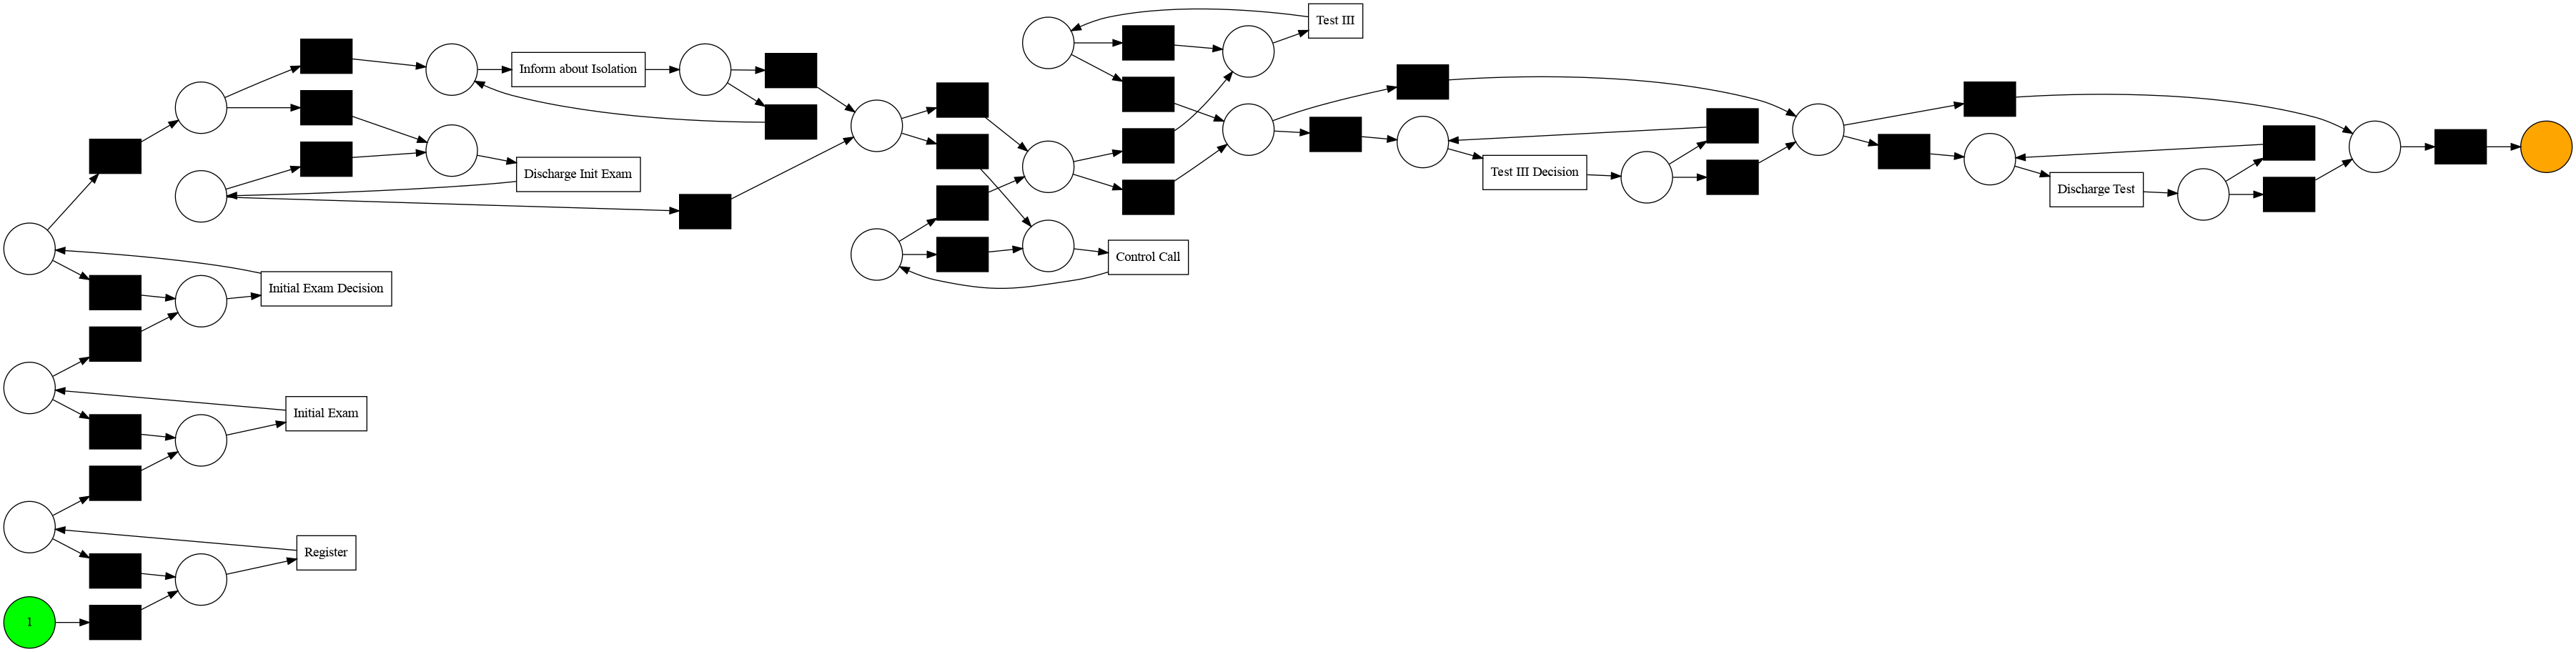

In [30]:
# your code
net1, initial_marking1, final_marking1 = inductive_miner.apply(filtered_log_variants)
gviz_pn1 = pn_visualizer.apply(net1, initial_marking1, final_marking1)
pn_visualizer.save(gviz_pn1, "./output/5/filterd_log_variants.png")
pn_visualizer.view(gviz_pn1)

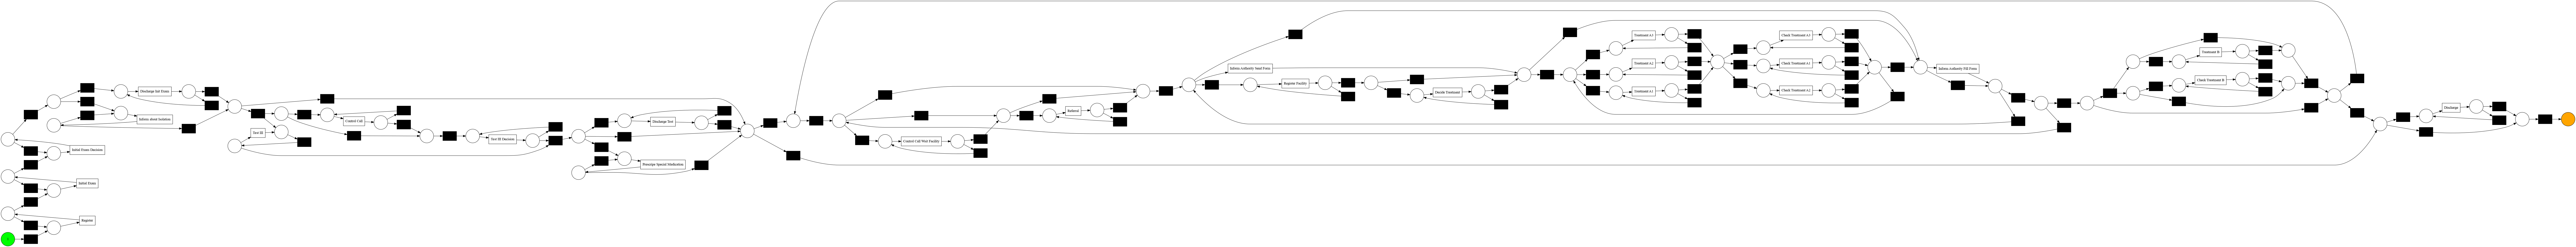

In [31]:
net2, initial_marking2, final_marking2 = inductive_miner.apply(filtered_log_insurance)
gviz_pn2 = pn_visualizer.apply(net2, initial_marking2, final_marking2)
pn_visualizer.save(gviz_pn2, "./output/5/filterd_log_insurance.png")
pn_visualizer.view(gviz_pn2)

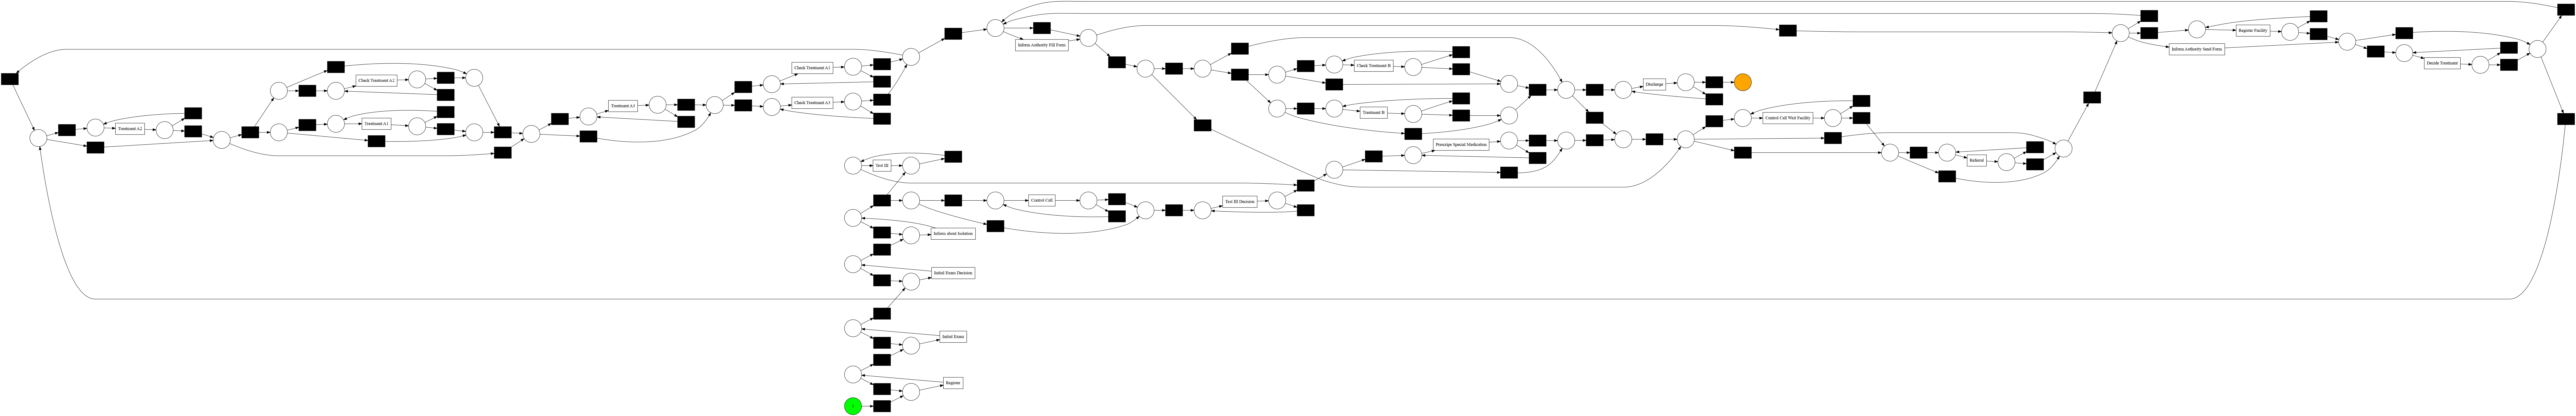

In [32]:
net3, initial_marking3, final_marking3 = inductive_miner.apply(filtered_log_cloud)
gviz_pn3 = pn_visualizer.apply(net3, initial_marking3, final_marking3)
pn_visualizer.save(gviz_pn3, "./output/5/filterd_log_cloud.png")
pn_visualizer.view(gviz_pn3)

Explanation: First process model (i.e 10% of most frequent traces): From the process model (also saved as '.png') we can observe that many sequential activities such as register, initial exam, initial exam decision (could end up in a loop for few cases), after initial exam decision there is an exclusive choice for discharge and isolation. 

If the path for Discharge Init Exam is chosen, we see that for a few cases there is direct discharge. For others, there is a loop and also a parallel path which joins with the path of Inform about isolation activity. And finally, control call is looped and test3, test3 decision and discharge test are a sequential activities but there are cases with loops here as well.

(f) Briefly summarize the differences and similarities of the models. Why do they differ/are similar?

Explanation: 

Similarities: 
We see that irrespective of the filter used, we see that all the traces will have common activities such as register, init exam, discharge, control, testing etc. In all the cases there are sequential, looping, parallel and exclusive paths for activities.


Differences:
The major difference between first and second or third models is since the first model only considers the 10% of the most frequent traces, thus the model is much simpler (less branching and loops) when compared to second and third models. 
For, in the second case of private insurance, we consider about half of all the traces both frequent and less frequent, these less frequent cases will have too many activities (corner cases) which will result is complicated loops and branching. 
In the third case, we consider people using only cloud-based services, although the number of cases is less the path is both frequent and infrequent which causes complicated model.


(g) Perform the token-based replay for conformance checking using your discovered model for **filtered_log_variants** and the original event log. Does your process model fit the log? Explain the result in one sentence. Calculate the trace and log fitness.

In [33]:
# your code
print(filtered_log_variants[0], '\n')
token_replay_result = token_replay.apply(filtered_log_variants, net1, initial_marking1, final_marking1)
print(token_replay_result[0], '\n')

fitness_tokenbasedreplay = replay_fitness_evaluator.apply(filtered_log_variants, net1, initial_marking1, final_marking1)
print(fitness_tokenbasedreplay, '\n')

{'attributes': {'patient': 1252, 'concept:name': 1252}, 'events': [{'time:timestamp': datetime.datetime(2020, 7, 5, 15, 21, 27, tzinfo=datetime.timezone.utc), 'concept:name': 'Register', 'lifecycle:lifecycle': 'start', 'ModelTime': 2971287, 'PatientName': 'Rudolf the 1252.', 'Age': 33, 'Insurance': 'STAT', 'org:resource': 'F0-A1', 'Type': nan}, '..', {'time:timestamp': datetime.datetime(2020, 7, 5, 16, 11, 20, tzinfo=datetime.timezone.utc), 'concept:name': 'Discharge Init Exam', 'lifecycle:lifecycle': 'complete', 'ModelTime': 2974280, 'PatientName': 'Rudolf the 1252.', 'Age': 33, 'Insurance': 'STAT', 'org:resource': 'F0-A1', 'Type': nan}]} 

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [tau_1, Register, skip_5, Register, skip_6, Initial Exam, skip_9, Initial Exam, skip_10, Initial Exam Decision, skip_13, Initial Exam Decision, skip_14, init_loop_15, Discharge Init Exam, skip_17, Discharge Init Exam, skip_18, skip_23, skip_28, skip_33, skip_38, tau_2], 'reached_

In [34]:
# your code
print(event_log[0], '\n')
token_replay_result2 = token_replay.apply(event_log, net1, initial_marking1, final_marking1)
print(token_replay_result2[0], '\n')

fitness_tokenbasedreplay2 = replay_fitness_evaluator.apply(event_log, net1, initial_marking1, final_marking1)
print(fitness_tokenbasedreplay2, '\n')

{'attributes': {'patient': 1, 'concept:name': 1}, 'events': [{'time:timestamp': Timestamp('2020-06-01 06:00:00+0000', tz='UTC'), 'concept:name': 'Register', 'lifecycle:lifecycle': 'start', 'ModelTime': 0, 'PatientName': 'Philipp the 1.', 'Age': 68, 'Insurance': 'STAT', 'org:resource': 'F0-A1', 'Type': nan}, '..', {'time:timestamp': Timestamp('2020-06-01 07:19:15+0000', tz='UTC'), 'concept:name': 'Discharge Test', 'lifecycle:lifecycle': 'complete', 'ModelTime': 4755, 'PatientName': 'Philipp the 1.', 'Age': 68, 'Insurance': 'STAT', 'org:resource': 'F0-A1', 'Type': nan}]} 

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [tau_1, Register, skip_5, Register, skip_6, Initial Exam, skip_9, Initial Exam, skip_10, Initial Exam Decision, skip_13, Initial Exam Decision, skip_14, init_loop_19, Inform about Isolation, skip_21, Inform about Isolation, skip_22, skip_23, init_loop_29, Test III, skip_31, Test III, skip_32, init_loop_34, Test III Decision, skip_36, Test III Decisio

Explanation: The model has a low fitness because many of the traces in the original event log does not match the conformance that is obtained by the model generated using only the most frequent traces.

### Frequency and performance

(h) Visualize the model for the **filtered_log_variants** event log enriched with frequency information. Subsequently, visualize that same model enriched with performance information.

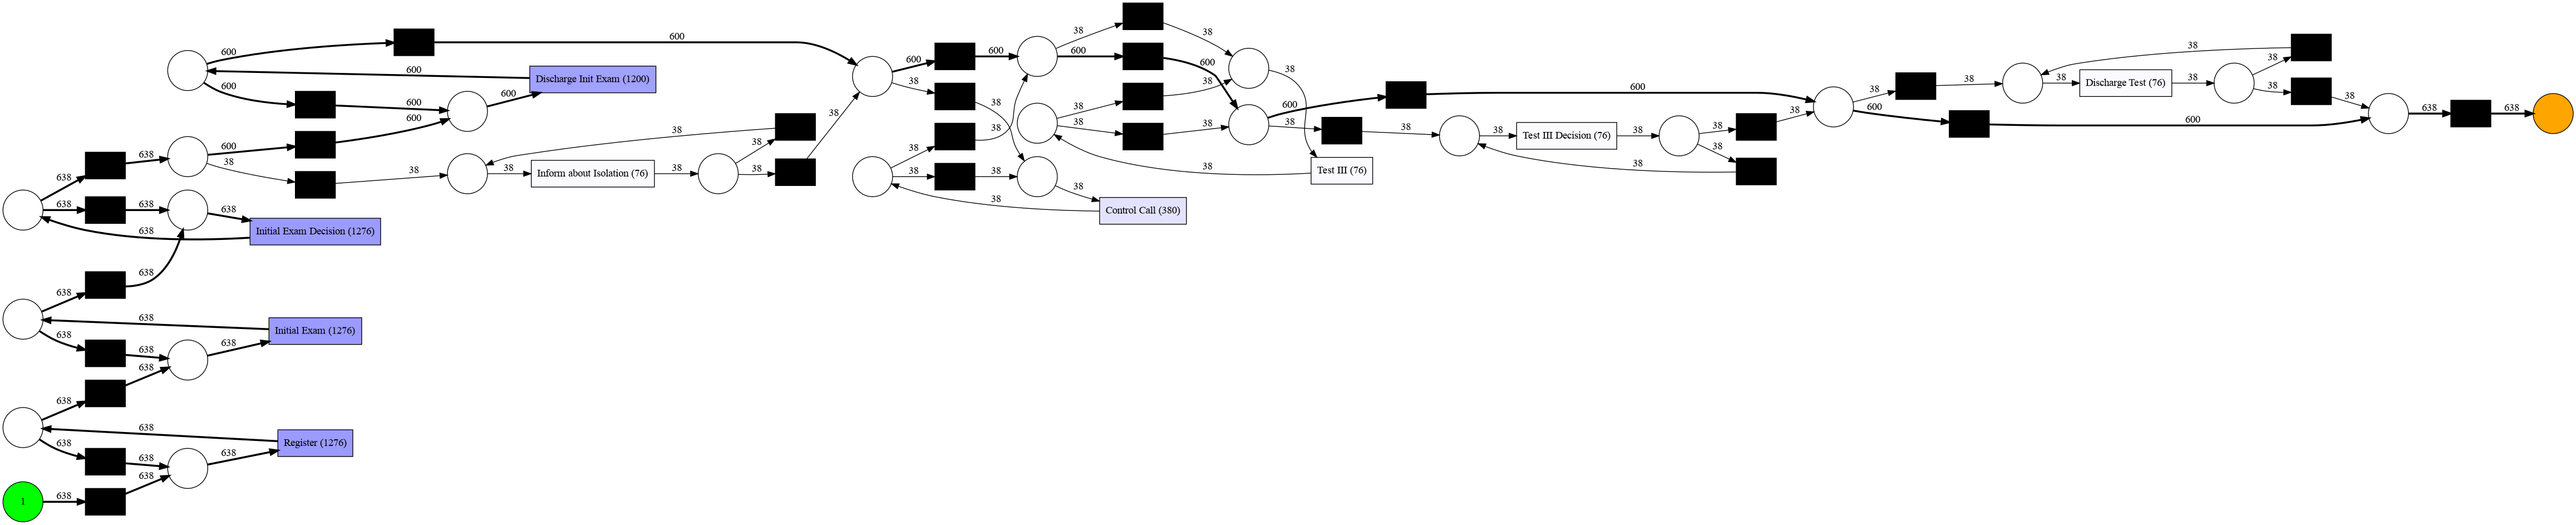

In [35]:
 # your code
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net1, initial_marking1, final_marking1, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=filtered_log_variants)
pn_visualizer.save(gviz, "./output/5/flv_frequency.png")
pn_visualizer.view(gviz)

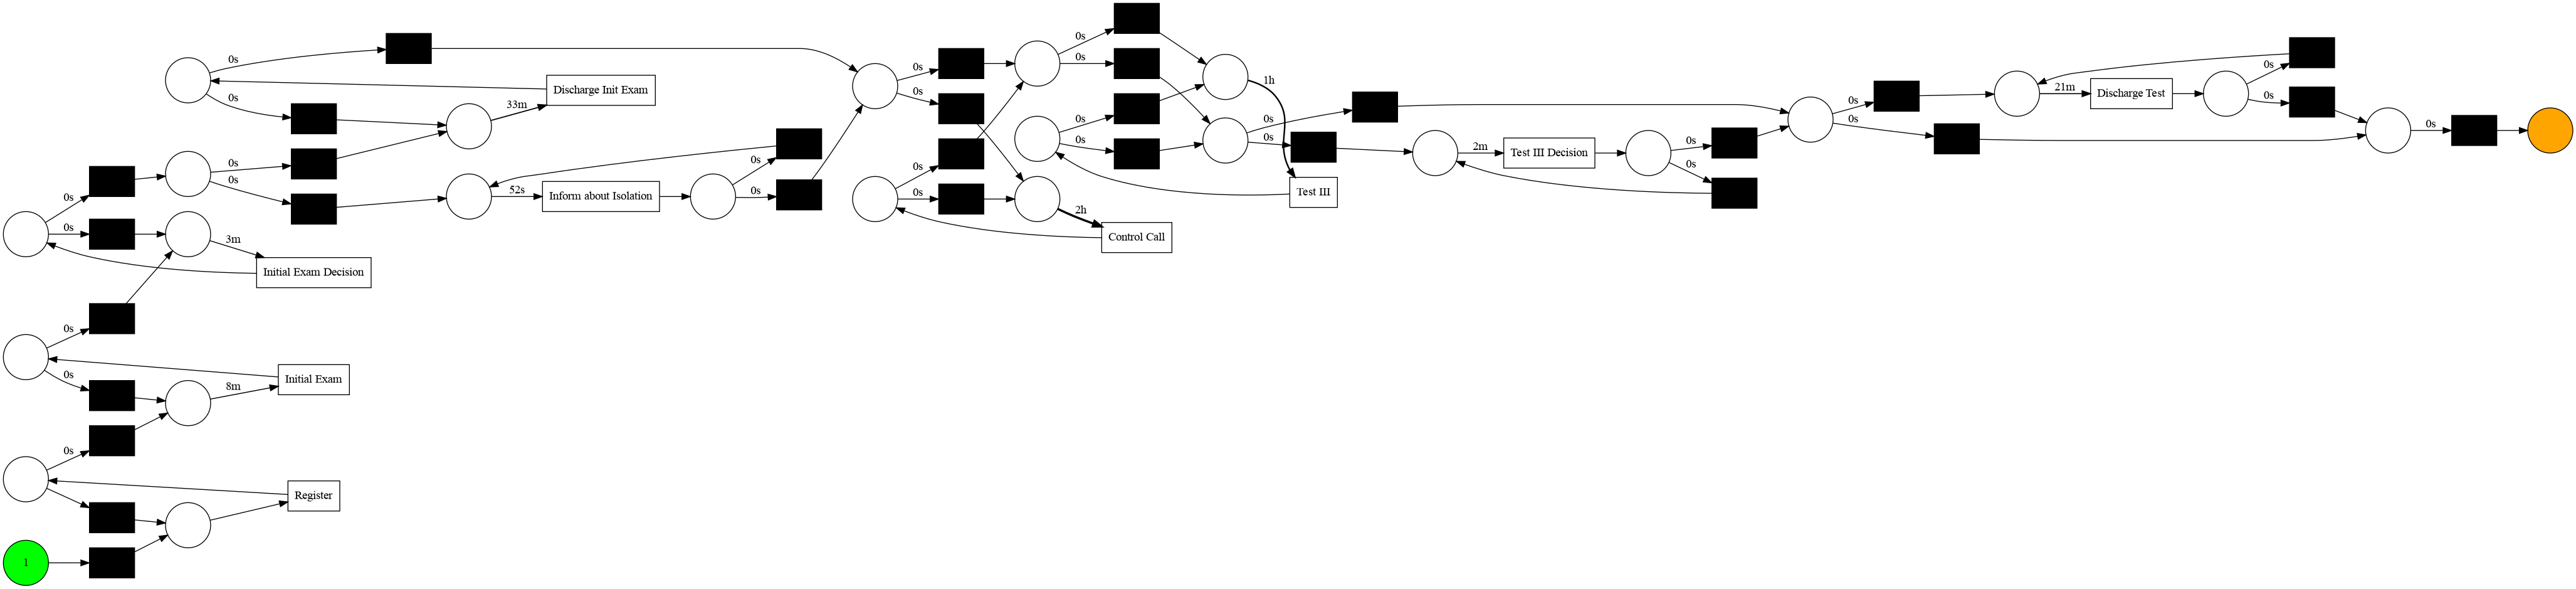

In [36]:
parameters = {pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net1, initial_marking1, final_marking1, parameters=parameters, variant=pn_visualizer.Variants.PERFORMANCE, log=filtered_log_variants)
pn_visualizer.save(gviz, "./output/5/flv_performance.png")
pn_visualizer.view(gviz)

(i) What are frequent activities? Why may they be frequent (think about the real life process described by the log)? What are possibly problematic activities according to the performance?

Explanation: 

Frequent activities represent the activities that are occurred most frequently in a log or activities frequent traces. 
They are frequent because they occur in many traces, in our case we show the frequency of the activities in 10% of the most frequent traces. 
By looking to the performance graphs, we see that before control call activity 2 hours is spent, test3 takes an hour and discharge init exam/test takes about half an hour, so there are the problematic activities based on performance. 

## Question 6 - Big Data (15 points): 

### Preparation: generating a simple log

In this question, we use the event log from the log csv file with the following modifications:
1. We flatten the lifecycles (i.e., start and complete) into a single event. Each event contains the start timestamp and complete timestamp.
2. A new column, called ServiceTime column, is included which represents the duration of the corresponding activity in the event.

We name the event log as **simple_log** in the remainder. Please follow the explanations below to prepare the **simple_log**. The preparation steps will not be graded.

In [22]:
# We use following utility functions for the modifications (these are given):
def _distinguish_duplicate_activities(log):
    """Add flags to the duplicate activities in a trace in order to distinguish them

    Keyword arguments:
    log -- even log
    """
    trace = list()
    activity_list = list()
    count=0
    prev_caseid=""
    for row in log.itertuples():
        activity=row.Activity
        caseid=row.Patient
        if(caseid!=prev_caseid):
            count=0
            prev_caseid=caseid
            trace=[]

        if activity in trace:
            count+=1
            activity = activity + "-{}".format(count)
            
        trace.append(activity)
        activity_list.append(activity)
    log["Activity"] = activity_list
    return log

def _merge_lifecylces(log):
    """Merge lifycycles (start,complete) into a single event. 

    Keyword arguments:
    log -- even log
    """
    start_log = log.loc[log["Lifecycle"]=="start"]
    start_log = _distinguish_duplicate_activities(start_log)
    
    complete_log = log.loc[log["Lifecycle"]=="complete"]
    complete_log = _distinguish_duplicate_activities(complete_log)

    complete_log["CompleteTime"] = complete_log["ModelTime"]
    simple_log = start_log.merge(complete_log, left_on=['Patient',"Activity"], right_on=['Patient',"Activity"],suffixes=("", "_y"))
    simple_log.drop(simple_log.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
    simple_log["ServiceTime"] = simple_log["CompleteTime"] - simple_log["ModelTime"]
    return simple_log

def produce_simple_log(filepath):
    """Produce simple log where the lifecycles are merged and service time information is added

    Keyword arguments:
    filepath -- path to event log
    """
    log = pd.read_csv(filepath, sep=',')
    log.sort_values(by=["Patient","ModelTime"],inplace=True)
    simple_log = _merge_lifecylces(log)
    return simple_log

**Preparation step 1**: Replace the filepath to your own filepath to produce the **simple_log**.  

In [23]:
import pandas as pd
#your filepath
filepath = "./Datasets/Quarantine_log.csv"
simple_log = produce_simple_log(filepath)

### Preparation: expanding the event log

In this question, we generate 100 event logs based on the <b>simple_log</b>. Each log replicates the base log (i.e., the <b>simple_log</b>). For randomization, you need to use the sum of the group's matriculation numbers (e.g., a group with 3 students having "100000", "100001", and "100002" as their matriculation numbers will use "300003" for the randomization).

In [24]:
# We use following utility functions for the modifications (these are given):
import random
def _randomize_case_attribute(log,matriculation_num):
    """Randomize case attributes based on the matriculation number

    Keyword arguments:
    log -- event log
    matriculation_num - sum of matriculation numbers
    """
    random.seed(matriculation_num)
    caseids = set(log["Patient"])
    for caseid in caseids:
        random_val = random.randint(-3,3)
        random.seed(random_val)
        log.loc[log["Patient"]==caseid,"Age"] = log.loc[log["Patient"]==caseid,"Age"]+random_val
    return log

def _extract_log(log,iter_num):
    """Extract n-th log to ./generated_logs/

    Keyword arguments:
    log -- event log
    iter_num -- n-th iteration
    """
    log.to_csv("./generated_logs/generated_log-{}.tsv".format(iter_num),header=False,index=False, sep="\t",line_terminator="")

def generate_log(original_log,num_replication,mat_num):
    """Generate logs (randomized by the matriculation number and extracted to ./generated_logs/) 

    Keyword arguments:
    log -- event log
    num_replication -- number of generated logs
    mat_num -- sum of matriculation numbers
    """
    import os
    dir_path = "./generated_logs"
    try:
        os.mkdir(dir_path)
    except OSError:
        print ("Directory already exists: %s" % dir_path)
    else:
        print ("Successfully created the directory %s " % dir_path)
    
    base_log = original_log.copy(deep=True)
    max_modeltime = max(base_log["ModelTime"])
    max_patientid = max(base_log["Patient"])
    for i in range(num_replication):
        generated_log = base_log
        generated_log["Patient"] += max_patientid
        generated_log["ModelTime"] += max_modeltime
        random.seed(None)
        randomized_log = _randomize_case_attribute(generated_log,random.randint(0,mat_num))
        _extract_log(randomized_log,i)
        print ("Successfully created %i th log at %s "% (i,dir_path))
        base_log = randomized_log

**Preparation step 2**: Generate 100 replicated logs in your local disk (./generated-logs/generated-log-0.tsv, ./generated-logs/generated-log-1.tsv, ..., ./generated-logs/generated-log-99.tsv). Do not forget to replace the SUM_MAT_NUM to yours.

In [25]:
#your group's sum
SUM_MAT_NUM = 1209550 
base_log = simple_log[["Patient", "ModelTime","Activity","Age","ServiceTime"]] # this will be removed
NUM_REPITITION=100
generate_log(base_log,NUM_REPITITION,SUM_MAT_NUM)

Directory already exists: ./generated_logs
Successfully created 0 th log at ./generated_logs 
Successfully created 1 th log at ./generated_logs 
Successfully created 2 th log at ./generated_logs 
Successfully created 3 th log at ./generated_logs 
Successfully created 4 th log at ./generated_logs 
Successfully created 5 th log at ./generated_logs 
Successfully created 6 th log at ./generated_logs 
Successfully created 7 th log at ./generated_logs 
Successfully created 8 th log at ./generated_logs 
Successfully created 9 th log at ./generated_logs 
Successfully created 10 th log at ./generated_logs 
Successfully created 11 th log at ./generated_logs 
Successfully created 12 th log at ./generated_logs 
Successfully created 13 th log at ./generated_logs 
Successfully created 14 th log at ./generated_logs 
Successfully created 15 th log at ./generated_logs 
Successfully created 16 th log at ./generated_logs 
Successfully created 17 th log at ./generated_logs 
Successfully created 18 th log 

### Basic Hadoop

(a) Now, it's time to work with the Hadoop system. The goal of this task is to merge 100 event logs at your disk in the Hadoop system. Follow the instructions below and show your results in each step (screenshots of the command line). We use "letter identifier" for this task (The letter identifier is the string consisting of the first letters of the group memebers' first names, e.g., for the group with "Alessandro Berti", "Bernardo Silva", "Chiao Li", the indentifier is "ABC").

    1) Import the event logs to your Docker engine (at /usr/local/hadoop/(identifier)-generated-logs/).
    2) Upload the files to the running Hadoop system (at /input/(identifier)-generated-logs/). 
    3) Merge the file and copy the result back to the Hadoop system (at /input/(identifier)-final-log.tsv).
    4) Using the Hadoop command, print out the merged file in the command line (the screenshot may contain 10 rows).

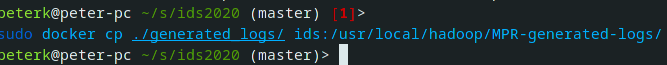

In [1]:
#your code
from IPython.display import Image
Image(filename='./output/screens/6_a_import.png') 

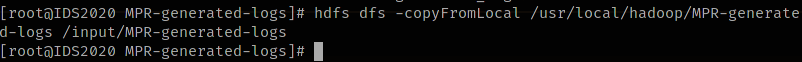

In [3]:
#your code
Image(filename='./output/screens/6_a_upload.png') 

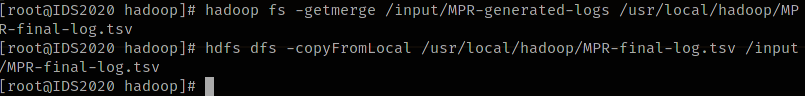

In [4]:
#your code
Image(filename='./output/screens/6_a_merge.png') 

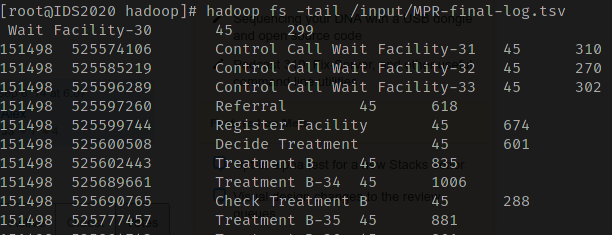

In [5]:
#your code
Image(filename='./screens/6_a_content.png') 

### Process Discovery

(b) Discover a process model from the merged file using MapReduce algorithms. Explain how you discover the process model with the following deliverables:

    1) Mapper function (as python file(s))
    2) Reducer function (as python file(s))
    3) Hadoop commands for MapReduce calculation (as text file)
    4) Jupyter notebook code that prints the directly-follows relations and discover process models based on the directly-follows relations (you are free to use any discovery algorithms)

<font color='red'>Important!</font> Please note that in this task, your result will be evaluated based on whether they are reproducible from your explanation. If you skip MapReduce calculations for this task, you will get 0 points.The deliverables of 1), 2), and 3) should be submitted as outputs. 

In [2]:
import csv
dfg = dict()
with open('./output/6_b/dfg.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        dfg[(row[0],row[1])] = int(row[2])


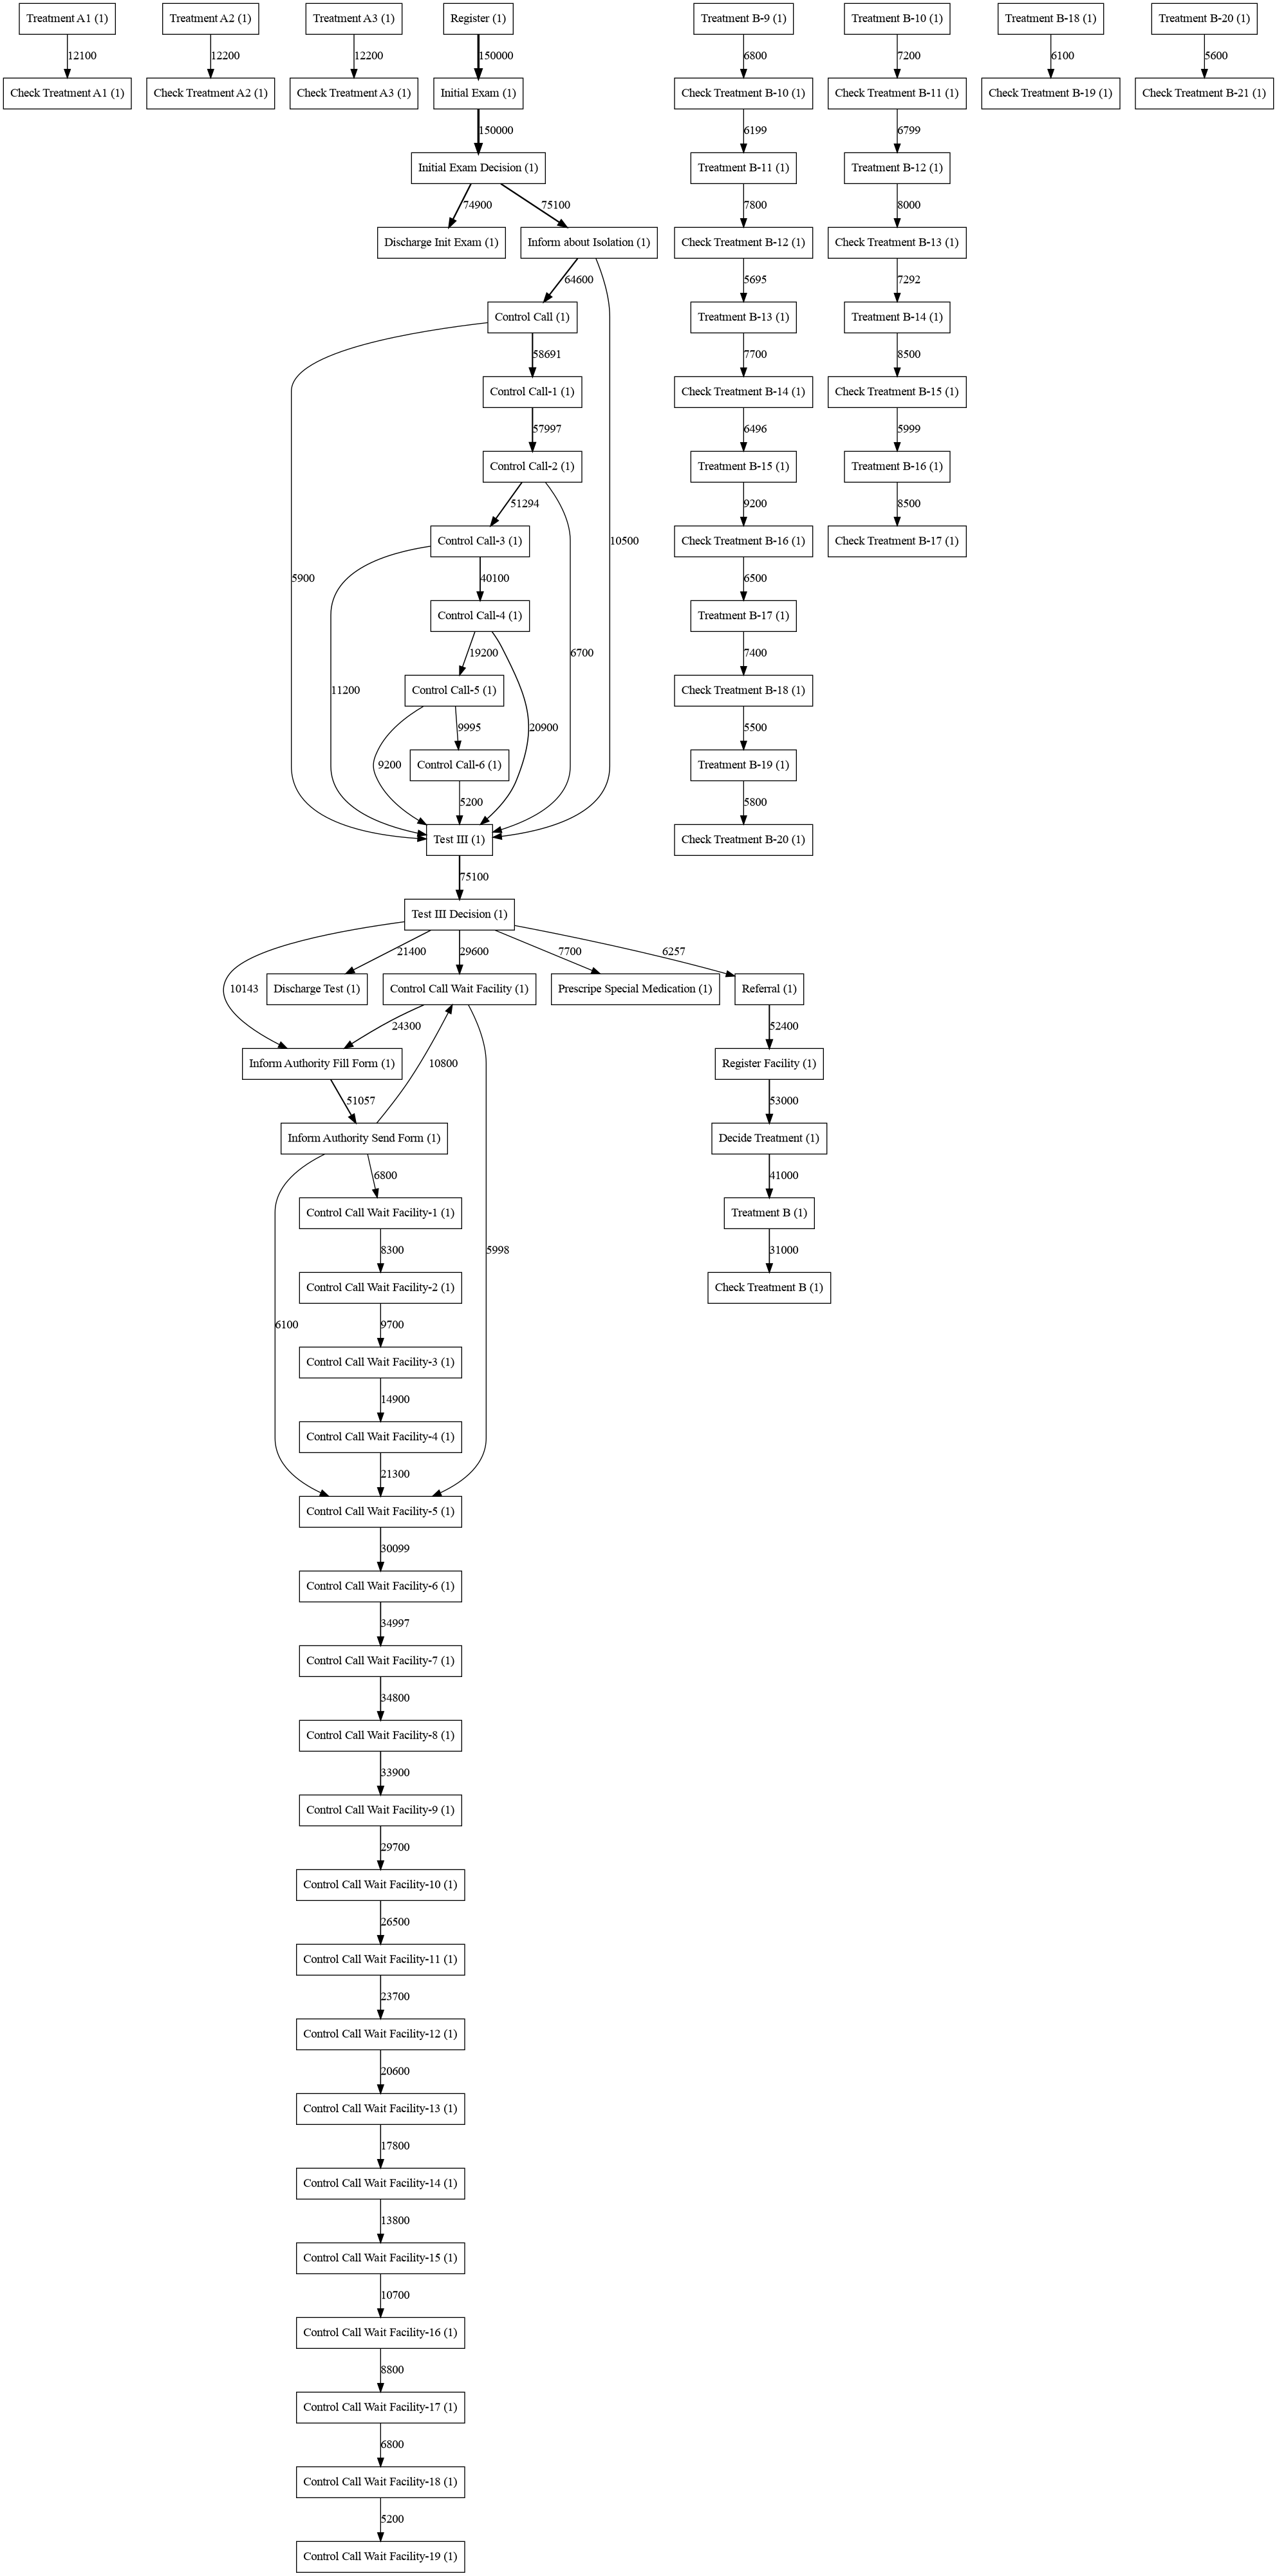

In [2]:
from pm4py.visualization.dfg import visualizer as dfg_vis


gviz = dfg_vis.apply(dfg)
dfg_vis.view(gviz)
dfg_vis.save(gviz, './output/6_b/dfg.png')

In [3]:
from pm4py.algo.discovery.inductive import algorithm as alg
from pm4py.visualization.petrinet import visualizer as petri_vis

disco = alg.apply_dfg(dfg)
disco

(<pm4py.objects.petri.petrinet.PetriNet at 0x7f7fb4949dd0>,
 ['source:1'],
 ['sink:1'])

In [4]:
gviz = petri_vis.apply(*disco)
print('Visualization generated, saving now')
petri_vis.save(gviz, './output/6_b/petri.png')

Visualization generated, saving now
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.534369 to fit


### Performance Analysis

(c) Calculate the total service time for each case using MapReduce algorithms. Explain how you calculate the total service time for each case with the following deliverables:

    1) Mapper function (as python file(s))
    2) Reducer function (as python file(s))
    3) Hadoop commands for MapReduce calculation (as text file)
    4) Result: total service times for cases (as text file)
    
Important! Please note that in this task, your result will be evaluated based on whether they are reproducible from your explanation. If you skip MapReduce calculations for this task, you will get 0 points.The deliverables of 1), 2), 3), and 4) should be submitted as outputs.

(d) Visualize 1000 cases with the longest total service time using any chart.

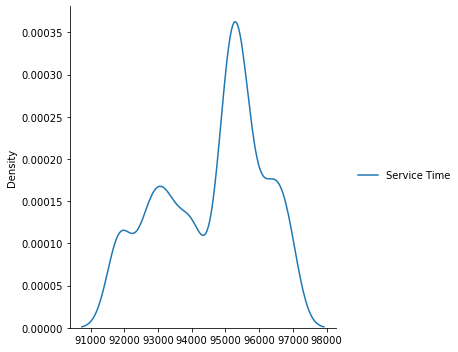

In [20]:
df = pd.read_csv('./output/6_c/service_times.csv', names=['CaseID', 'Service Time'], index_col=0)
sns.displot(data=df.nlargest(1000,columns=['Service Time']), kind='kde')